# Chapter 11. 状態空間モデル

この章では、2020年代に長期記憶を扱うニューラルネットワークとして脚光を浴びた状態空間モデルを扱います。

## 前書き

### 長期記憶の重要性と状態空間モデル

これまでESNを題材に、RNNの中で記憶がどのように解析されるかを説明してきました。
特に記憶容量 (MC) 、記憶関数 (MF)、情報処理容量 (IPC) といったRCの指標を用いると、力学系において入力時系列の情報がその状態の上でどの程度保持されるかが定量化され、かつその上限や内訳も「解剖」して議論されます。
MCはもともとH. Jaegerら<sup>[1]</sup>によって提案された指標ですが、その論文のタイトル"Short-term memory in echo state networks"が示すように「短期」記憶の評価を目的として導入されました。
すなわち力学系の次元 $N$ に対して、同等から数倍程度のステップ数の過去入力情報がどの程度保持されるかを評価するのに一般的には用いられます。
これまで学んだように入力時系列がi.i.d.な分布から生成されるとき、MCの上限は高々 $N$ になるので、多くのケースではそれで十分に有用な情報が得られます。
一方でMCは普遍的な指標なので、システムのサイズより遥かに大きい時間スケールの「長期」記憶の評価に対しても適用できます。
例えば有意な値が得られるかは別にして、数100ノードのESNに対して数万〜数十万ステップ前の情報に対してMFを計算することも可能です。
ただし通常のESNとその初期化方法では、これまで見てきたとおりほとんどのケースでMFがノイズと区別がつかないレベルで急速に減衰するため、そういった長期記憶の実現は一般に困難です。
特に線形な記憶特性しか持たない線形ESNの場合は単調にMFは減少する (非線形の場合にはその限りでない点に注意) ので、長期記憶を実現するには工夫が必要になります。

RCの文脈とは別に、長期記憶の重要性はGPTに代表される大規模言語モデル (LLM) の文脈で近年高まっています。
GPT-2<sup>[2]</sup>の登場以降、長文の処理や生成にTransformer<sup>[3]</sup>が組み込まれたニューラルネットワークが盛んに用いられるようになりました。
Transformerでは処理したい文章はトークン毎に分割され、各トークンがモデルの入力としてはじめから順番に入力されます。
その際に、現実の小説や評論、あるいは人間との対話がそうであるように、文章全体を包括的に理解するためにはしばしば数千〜数万トークンにわたる長期の文脈を保持しかつ適切に処理しなければなりません。
しかしながらAttention機構が組み込まれたTransformerでは、入力トークン列の長さが $L$ のとき時間計算量が $O(L^2)$ となるため、タスクの長期依存性が高くなるほど計算が困難になります。
またニューラルネットワークの隠れ状態の次元 $N$ に対して、パラメータの保持と行列ベクトル積にそれぞれ $O(N^2)$ のメモリと計算時間を必要とするため、できるだけ少ないパラメータ数での実現が好ましいと言えます。

こうした背景から登場したのが、2020年に公開されたベンチマークタスク群であるLong-Range Arena (LRA)<sup>[4]</sup>です。
LRAでは長期記憶が必要な様々なタスクが用意されており、これを機に長期記憶タスクに適したニューラルネットワークの研究・開発が盛んになりました。
この章で扱われる **状態空間モデル (State Space Models; SSM)<sup>[5,6,7,8]</sup>** と呼ばれるアーキテクチャはこのLRAを通じて脚光を浴びました。
SSMを組み込んだ **S4 (Structured State Space Sequence model)<sup>[6]</sup>** は、LRAにおいて当時のSoTAを大きく上回る性能を示したのです。
特にLRAの一つであるPathfinderタスクの中で最も難しいPathfinder-X (Path-X)において、Transformerをはじめとする既存のAttentionベースのモデルがほぼ解けなかった (ランダム推測と同程度の精度しか出せない) 中で、S4は唯一高い精度を示しました。
またSSMはその後、選択メカニズムと合わせてMamba<sup>[9]</sup>においても組み込まれ、Transformerを改良し代替しうる高速かつ効率的な生成モデルとして、2025年現在継続的に注目されています。

### リザバーとしてのSSM

さてこのSSMですが、内部結合の設定が特殊ではあるものの、実はその中身は線形RNNに分類されます。
またESNのように内部結合パラメータを固定化しても、その長期記憶特性を損なわずに学習・推論できます。
つまりSSMは長期記憶を有するリザバーとみなせるのです。
これがまさしく本RC bootcampでSSMを取り上げる理由です。
実際、S4が提案された論文では、複数のSSMと活性化関数を交互に配置した多層構造が用意され、そのモデルパラメータが学習されました。
この際SSM、すなわち線形RNN部分のパラメータを初期化後に固定化して学習させても、誤差逆伝搬法<sup>[10]</sup>で内部結合を含め全体を学習させる条件と比較して、あまり変わらない精度が得られたと報告されています<sup>[6]</sup>。
この条件のモデルは線形ESNが組み込まれた、いわゆる深層リザバー計算<sup>[11]</sup>のアーキテクチャと実質的に等価であるといえ、そこでは長期記憶の保持をリザバーが担っているといえます。
また同様の結果はその後の研究<sup>[12]</sup>でも実験的に確認され、かつMFと絡めてそのメカニズムが議論されました。
これらの一連の結果はSSM部分のパラメータの初期化方法自体に長期記憶を実現するための秘訣が含まれている可能性を示唆しています。

このようにSSMは長期記憶を扱う特殊な線形リザバーとみなせ、これまで学習してきたRCに対する知識を活かしてより深くそのメカニズムを理解できると考えられます。
この章では、SSMの理論的背景にあるHiPPOフレームワーク<sup>[5]</sup>と、SSMが組み込まれたアーキテクチャであるS4・S4D<sup>[6,7]</sup>を題材に、RCの観点から長期記憶を扱うニューラルネットワークの実装方法とそのメカニズムの理解を目指しましょう。

### SSMの定式化

まずはSSMの定式化を行います。
SSMは $t$ 上で定義される1次元の入力時系列 $u(t)$ から $N$ 次元の内部状態 $x(t)~(N\in\mathbb{Z^{+}})$ を介して、1次元の出力時系列 $y(t)$ を生成するseq2seqモデル (時系列から時系列へ変換するモデル) の総称です。
この際SSMを表現するために、以下の連続時間 $t\in[-\infty, \infty]$ 上で定義される以下の形式がよく用いられます。

$$
\begin{align}
\frac{dx}{dt}(t) &= A(t)x(t) + B(t)u(t) \\
y(t) &= C(t)x(t) + D(t)u(t)
,\end{align}
$$

ここで、$x(t)\in\mathbb{R}^{N}$は状態、$A(t) \in \mathbb{R}^{N \times N}$ は状態行列、 $B(t) \in \mathbb{R}^{N \times 1}$ は入力行列、 $C(t) \in \mathbb{R}^{1 \times N}$ は出力行列、そして $D(t) \in \mathbb{R}^{1 \times 1}$ は直達行列と呼ばれるSSMの挙動を決定するパラメータです。
式の形に見覚えがある方がいるかもしれませんが、制御工学の文脈で古くから用いられてきた形式です。
今SSMに長期記憶特性を持たせるためには、 $x(t), y(t)$ が $u(t)$の 過去の情報を長い期間反映したものである必要があります。
特に式(2)は実質的に動的な線形リードアウト層であるので、 $x(t)$ の挙動を決定する式(1)とそのパラメータ$A(t), B(t)$が特に重要であると言えます。
そこでパラメータ $A(t), B(t)$ を有するSSMをSSM $(A(t), B(t))$ と表記します。

また一般性のためSSMのパラメータを時変な形式で書きましたが、特にパラメータを時不変にした $A(t)=A, B(t)=B, C(t)=C, D(t)=D$ が用いられます。
この場合システムは線形時不変 (LTI; Linear Time-Invariant)で、この形式で表されるSSMをTSMM (Time-invariant State Space Model) と呼称しSSM $(A,B)$ と表記します。
この際 $y(t)$ はカーネル関数 $K(t)$ (インパルス応答、すなわち $u(t)=\delta (t)$ に対する応答と同じ)を 用いて以下の式で明示的に計算できます。

$$
\begin{align*}
K(t) &= C e^{tA} B \\
y(t) &= (K * u)(t)  \\
&=\int_{0}^{t} K(t-s) u(s) ds
.\end{align*}
$$

以下特に表記がなければ $D=0$ とします。
後述しますが、この式は畳み込み計算のアルゴリズムによって、コンピュータ上で効率的に計算できます。
しばしばシステムがTSSMに限定される理由はこの計算のしやすさにあります。
また $e^{tA}B$ は $N$ 次元のベクトルであり、その各成分の値 $K_n(t):= (e^{tA}B)_n$ はSSMの基底関数と呼ばれます。
これは $C=e_{n}^\top(:=[0,~\ldots,~0, 1, 0,~\ldots,~0])$ (ただし1は $n$ 番目の成分) としたときのカーネル関数に対応します。

### HiPPOフレームワーク

次にSSMから一旦離れて、**HiPPO (High-order Polynomial Projection Operator) フレームワーク**の概念を説明します。
HiPPOフレームワークは時々刻々とシステムに入力される時系列データを時系列そのものを保持せずに、システムの有限次元の状態 $x(t) \in \mathbb{R}^{N}$ の上で圧縮して表現するために導入された枠組みです。
換言すれば時刻 $t$ において、 $t$ 以前の過去時系列 $u_{\leq t}:=u(s)|_{s \leq t}$ の $N$次元ベクトル $x(t)$ として表現を目指します。
ここでまず重要な点として、HiPPOフレームワークではこの圧縮表現の問題を、関数空間における基底関数に対する係数の更新問題に置き換えて定式化します。
すなわち $\{p^{(t)}_{n}(s)\}_{n=0}^{N-1}$ を時刻 $t$ における任意の基底関数 (基底が時変の場合も含めて一般化しています) として、 以下の形での $u_{\leq t}$ の近似を目指します。

$$
\begin{align*}
u_{\leq t}(s) &\approx p^{(t)}(s) \\
&:=\sum_{n=0}^{N-1} x_{n}(t) p^{(t)}_{n}(s) \quad (s \in [-\infty,t])
.\end{align*}
$$

別の言葉で表現すれば、$\{p^{(t)}_{n}(s)\}_{n=0}^{N-1}$ を基底関数とした関数空間の$N$ 次元の部分空間に、$u_{\leq t}$ を 射影した関数が $p^{(t)}(s)$ であり、その係数が $x(t)=(x_0(t),~\ldots,~x_{N-1}(t))^{\top}$ であるといえます。

さて上記の近似を評価する上で関数空間上における距離が必要になります。
この際時刻 $t$ 以前の時間 $[-\infty,t]$ 上で定義されるある測度 $\mu^{(t)}(s)$ (ただし$\int_{-\infty}^{t} d\mu^{(t)}(s) = 1$) を用いて以下の形で内積が定義されます。

$$
\begin{align*}
\langle {u,p^{(t)}} \rangle_{\mu^{(t)}} = \int_{-\infty}^{t} u(s) p^{(t)}(s) d\mu^{(t)}(s)
.\end{align*}
$$

後ほど再度登場し説明されますが、測度 $\mu^{(t)}$ はいわば連続時間における重み付けであり、 $[-\infty, t]$ のうちどの部分の入力時系列を重要視して近似するかを決定します。
同様に $L_{2}$ ノルムは以下の式で定義されます。

$$
\begin{align*}
\|u\|_{L_{2}(\mu^{(t)})} = \sqrt{\langle {u,u} \rangle_{\mu^{(t)}}}
.\end{align*}
$$

最終的にHiPPOフレームワークの問題は以下の距離を最小化する $\{x_n{(t)}\}_{n=0}^{N-1}$ の最適化問題として定式化されます。

$$
\begin{align}
p^{(t)} = \arg\min \|u_{\leq t} - p^{(t)}\|_{L_{2}(\mu^{(t)})} \tag{3}
.\end{align}
$$

HiPPOフレームワークでは、$p^{(t)}$ を明示的に計算する代わりに、式(3)を最小化する係数 $\{x_{n}(t)\}_{n=0}^{N-1}$ の計算を各時刻 $t$ において目指します。
言い換えれば、以下の式で定義される写像 $\mathrm{hippo}: (\mathbb{R}_{\leq t} \to \mathbb{R}) \to (\mathbb{R}_{\leq t} \to \mathbb{R}^{N})$ の構築がHiPPOフレームワーク全体の目的となります。

$$
\begin{align*}
\mathrm{hippo}(u_{\leq t}) := \{x_{n}(t)\}_{n=0}^{N-1} \quad \text{s.t. minimizing} \quad \left\|u_{\leq t} - \sum_{n=0}^{N-1} x_{n}(t) p^{(t)}_{n}\right\|_{L_{2}(\mu^{(t)})}
.\end{align*}
$$

このようにHiPPOフレームワークは、時刻 $t$ 以前の入力時系列を有限の $N$ 次元ベクトルで表現するために、所定の基底関数に対する係数を各時刻 $t$ において計算します。

### HiPPOとSSMの関係

ここまで抽象的な説明が続きましたが、そのような写像 $\mathrm{hippo}$ は具体的にどのように構築され計算されるでしょうか？
実は、適切に測度 $\mu^{(t)}$ と基底関数 $\{p_{i}^{(t)}\}_{i=0}^{N-1}$ の組み合わせを選ぶと、$\mathrm{hippo}$ の計算は式(1)の形式で表現されるあるSSMの解の求積に対応します。
言い換えれば、式 (1) において適切に $A(t), B(t)$ を設計してSSM $(A(t), B(t))$ を構築すると、その状態 $x(t)$ の時間発展 (求積) によって、ある測度と基底関数における $\mathrm{hippo}(u_{\leq t})$ の計算が完了してしまうのです。
これがHiPPOフレームワークの重要な成果です<sup>[5]</sup>。
またある測度 $\mu^{(t)}$ において基底関数 $\{p^{(t)}_{n}\}_{n=0}^{N-1}$ が直交基底であるとき、すなわち

$$
\begin{align*}
x_n(t) &= \langle {u_{\leq t}, p^{(t)}_n} \rangle_{\mu^{(t)}} \\
\langle {p^{(t)}_{i}, p^{(t)}_{j}} \rangle_{\mu^{(t)}} &= \delta_{ij} \quad (i,j=0,1,~\ldots,~N-1)
,\end{align*}
$$

を満たすとき、そのようなSSM $(A(t), B(t))$ はOSSM (Orthogonal State Space Model) と呼ばれます。
また特にTSSMかつOSSMである場合、そのSSM $(A, B)$ はTOSSM (Time-invariant Orthogonal State Space Model) と呼称されます。
このとき $p^{(t)}(s)=: p(t-s)$ 、 $\mu^{(t)}(s)=:\mu(t-s)$ と $t-s$ のみに依存する形式で表現され、かつSSMの基底関数 ($p^{(t)}_{n}$ とは異なる)に関して $K_n(t-s) = p^{(t)}_{n}(s) \mu^{(t)}(s)$ を満たすので非常に扱いやすくなります。
実際にHiPPOフレームワークが提案された論文<sup>[5]</sup>ではTOSSMとなるSSM $(A, B)$ を構成する具体例が紹介されています。
次の節から論文で紹介されたいくつかのTOSSMの実装を通じて、HiPPOフレームワークを理解していきましょう。

## 演習問題と実演

ここからは実際にコードの実装を行いながら、SSMとHiPPOフレームワーク、ならびにそれらが組み込まれたアーキテクチャの理解を目指します。
前回と同様、各種ライブラリおよび実装済みの関数の`import`を行うために次のセルを実行してください。
なお内部実装を再確認するには、`import inspect`以下の行をコメントアウトするか`...?? / ??...`を使用してください。

In [ ]:
import math
import sys

import matplotlib
import numpy as np
import scipy
from matplotlib.animation import FuncAnimation

matplotlib.rc("animation", html="jshtml")

if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore Csonnecting to google drive

    if False:  # Set to True if you want to use Google Drive and save your work there.
        drive.mount("/content/gdrive")
        %cd /content/gdrive/My Drive/rc-bootcamp/
        # NOTE: Change it to your own path if you put the zip file elsewhere.
        # e.g., %cd /content/gdrive/My Drive/[PATH_TO_EXTRACT]/rc-bootcamp/
    else:
        pass
        %cd /content/
        !git clone --branch ja_sol https://github.com/rc-bootcamp/rc-bootcamp.git
        %cd /content/rc-bootcamp/
else:
    sys.path.append(".")

from utils.reservoir import ESN, Linear
from utils.style_config import Figure, plt
from utils.tester import load_from_chapter_name
from utils.tqdm import tqdm, trange

test_func, show_solution = load_from_chapter_name("11_state_space_model")

# Uncomment it to see the implementations.
# import inspect
# print(inspect.getsource(Linear))
# print(inspect.getsource(ESN))

# Or just use ??.../...?? (uncomment the following lines).
# Linear??
# RidgeReadout??
# ESN??

### TOSSMの実装

#### HiPPO-LegT

まずHiPPO-LegT (truncated Legendre polynomials) と呼ばれるTOSSMを実装しましょう。
HiPPO-LegTは以下の式で表される SSM $(A, B)$ です。

$$
\begin{align*}
A_{nk} &= \frac{1}{\theta} \sqrt{(2n+1)(2k+1)} \begin{cases}
-1 &\quad \text{if} ~n \geq k \\
(-1)^{n-k+1} &\quad \text{if} ~n \leq k \\
\end{cases} \tag{HiPPO-LegT A} \\
B_n &= \frac{1}{\theta} \sqrt{2n+1} \tag{HiPPO-LegT B}
,\end{align*}
$$

ただし $0 \leq n, k \leq N-1$ です。
詳細な証明は省きますが、このSSM $(A, B)$に対応するHiPPOの測度 $\mu^{(t)}(s)$ と直交基底関数 $\{p^{(t)}_n(s)\}_{n=0}^{N-1}$  は以下の式で与えられます (導出は論文<sup>[5,8]</sup>を確認してください)。

$$
\begin{align*}
\mu^{(t)}(s) &= \frac{1}{\theta} \mathbb{1}_{[t-\theta, t]}(s) \quad (\theta > 0) \\
p^{(t)}_n(s) &= \sqrt{2n+1} L_n\left(1 - \frac{2(t-s)}{\theta}\right) \cdot \mathbb{1}_{[t-\theta, t]}(s)
,\end{align*}
$$

ここで $\mathbb{1}_{[t-\theta, t]} (s)$ は指示関数であり、$s \in [t-\theta, t]$ のときのみ 1、それ以外 0を出力する関数になります。
この場合、測度 $\mu^{(t)}(s)$ が過去 $\theta$ 分 **のみ** の入力時系列情報を加味する重み付けを行うと言えます。
また $L_n$ は $n$ 次のルジャンドル多項式、$\theta$ は時間幅を表します。
このようにHiPPO-LegTでは $[-1, 1]$から $[t-\theta, t]$ 上で直交するように変換された $n$次のルジャンドル多項式 $p^{(t)}_n(s)$ を基底関数として用い、 過去 $\theta$ 分の入力時系列を $[t-\theta, t]$ の範囲で近似します (※論文とは異なり、$\mathbb{1}_{[t-\theta, t]}$ が基底関数に含まれていますが、これは範囲外での $L_n$ の発散を防ぐためで、実践的には問題ありません)。

まずはじめにこの $A, B$ を実装しましょう。

Q1.1.

上記の式で定義される HiPPO-LegT の $A, B$ を構築する関数`transition_leg_t`実装せよ。
ただし 行列のサイズ $N > 0$ および時間幅 $\theta > 0$ は引数として与えられるものとする。

- `transition_leg_t`
  - Argument(s):
    - `N`: `int`
      - $N > 0$
    - `theta`: `float`
      - $\theta > 0$
  - Return(s):
    - `A`: `np.ndarray`
      - `shape`: `(N, N)`
      - `dtype`: `np.float64`
    - `B`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64`

In [ ]:
def transition_leg_t(N, theta=1.0):
    # TODO
    arange = np.arange(N)
    base = (2 * arange + 1) ** 0.5
    diff = arange[:, None] - arange[None, :]
    A = base[:, None] * base[None, :]
    A[(diff >= 0) | (diff % 2 == 0)] *= -1
    B = np.array(base)[:, None]
    A /= float(theta)
    B /= float(theta)
    return A, B
    # end of TODO


test_func(transition_leg_t, "01_01", multiple_output=True)
# show_solution("01_01", "transition_leg_t")  # Uncomment it to see the solution.

次にHiPPO-LegTに対応する測度 $\mu^{(t)}(s)=\frac{1}{\theta} \mathbb{1}_{[t-\theta, t]}(s)$ と基底関数 $p^{(t)}_n(s) = \sqrt{2n+1} L_n\left(1 - \frac{2(t-s)}{\theta}\right) \cdot \mathbb{1}_{[t-\theta, t]}(s)$ を実装してみましょう。
特に $t$ の変化に対して形状が変わらない (スライドで不変) ので $t=0$ として $s\in (-\infty, 0]$ 上でそれぞれを実装しましょう。
まずは測度 $\mu^{(0)}(s)$ を実装します。

Q1.2.

長さ $T$ の時間列 $S=\{s_0, s_1,~\ldots,~s_{T-1}\}$ ならびにパラメータ $\theta>0$ に対して、$t=0$ の時のHiPPO-LegTの測度 $\mu^{(0)}(s)$ を計算する関数`measure_leg_t`を実装せよ。

- `measure_leg_t`
  - Argument(s):
    - `S`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`
    - `theta`: `float`
      - $\theta > 0$
  - Return(s):
    - `measure`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`

- [`numpy.where`](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

In [ ]:
def measure_leg_t(S, theta=1.0):
    # TODO
    measure = np.where((-theta <= S) & (S <= 0), 1.0 / theta, 0.0)
    return measure
    # end of TODO


test_func(measure_leg_t, "01_02")
# show_solution("01_02", "measure_leg_t")  # Uncomment it to see the solution.

次は基底関数 $p^{(0)}_n(s)$ を実装しましょう。
IPCを学んだ章で実装したメモ化によって効率的に計算する `Legendre` クラスをそのまま利用できます。

Q1.3.

$x(t)$ の次元 $N > 0$ 、長さ $T$の 時間列 $S = \{s_0, s_1,~\ldots,~s_{T-1}\}$ ならびにパラメータ $\theta > 0$ が与えられたとき、$t=0$ の時のHiPPO-LegTの基底関数 $p^{(0)}_n(s)$ を計算する関数 `basis_leg_t` を実装せよ。

- `basis_leg_t`
  - Argument(s):
    - `N`: `int`
      - $N > 0$
    - `theta`: `float`
      - $\theta > 0$
    - `S`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`
  - Return(s):
    - `basis`: `np.ndarray`
      - `shape`: `(N, T)`
      - `dtype`: `np.float64`

<details><summary>tips</summary>

- `Legendre??` によって実装を確認せよ。あるいは IPC の章を参照せよ。

</details>

In [ ]:
from ipc_module.polynomial import Legendre


def basis_leg_t(N, S, theta=1.0):
    # TODO
    basis = np.zeros((N, len(S)))
    non_zero = (-theta <= S) & (S <= 0)
    poly = Legendre(1 + 2 * S[non_zero] / theta)
    for idx in range(N):
        basis[idx, non_zero] = poly[idx]  # Evaluate the n-th order polynomial.
    basis[:, non_zero] *= ((2 * np.arange(N) + 1) ** 0.5)[:, None]
    return basis
    # end of TODO


test_func(basis_leg_t, "01_03")
# show_solution("01_03", "basis_leg_t")  # Uncomment it to see the solution.

HiPPO-LegTでは $[t-\theta, t]$ 上での値が加味されるので、$t=0$ として $s \in [-2\theta, 0]$ 上での $p^{(0)}_n(s)$ の挙動を描画してみましょう。

In [ ]:
def plot_basis(ss, basis, products, plot_num):
    fig = Figure(figsize=(14, 4))
    fig.create_grid(1, 2, width_ratios=(2, 1))
    fig[0].plot(ss, basis[:plot_num].T, lw=1.0)
    fig[0].tick_params(axis="both", labelsize=12)
    fig[0].set_xlabel("Time $s$", fontsize=14)
    fig[0].set_ylabel("Basis $p^{(0)}_n(s)$", fontsize=14)
    fig[1].tick_params(axis="both", labelsize=12)
    _im, cb = fig[1].plot_matrix(
        products,
        cmap="Blues",
        vmin=0,
        vmax=None,
        aspect="equal",
        colorbar=True,
    )
    fig[1].set_xticks(range(plot_num))
    fig[1].set_xticklabels(range(plot_num))
    fig[1].set_yticks(range(plot_num))
    fig[1].set_yticklabels(range(plot_num))
    cb.ax.tick_params(labelsize=12)
    return fig


num_basis, theta, dt = 16, 2.0, 1e-4
plot_num = 8

ss = np.linspace(-2 * theta, 0, int(2 * theta / dt) + 1)
measure = measure_leg_t(ss, theta=theta)
basis = basis_leg_t(num_basis, ss, theta=theta)
products = (basis[:plot_num] * measure) @ basis[:plot_num].T * dt  # Inner products among bases p for μ
fig = plot_basis(ss, basis, products, plot_num)
fig[0].set_title("HiPPO-LegT Basis Functions ($\\theta={:.2f}$)".format(theta), fontsize=14)
fig[1].set_title("Inner Products", fontsize=14)

None

ご覧のとおり、$[-\theta, 0]$ 上ではルジャンドル多項式が変換された波形が見られる一方で、$[-2\theta, -\theta)$ 上では0になっていることがわかります。
また右の図より、これらの基底の直交性 ($\langle {p^{(0)}_i, p^{(0)}_j} \rangle_{\mu^{(0)}} = \delta_{ij}$ ) も確認できます。
HiPPO-LegTはTOSSMなので、各時刻 $t$ における測度 $\mu^{(t)}(s)$ と基底関数 $p^{(t)}_{n}(s)$ はこのグラフを右に $t$ だけシフトさせたものになります。
したがってこの基底関数の値はどの時刻でも再利用できます。

さてデモに移る前に、コンピュータ上で常微分方程式の求積を行うために式(1)の常微分方程式の離散化を行わなければなりません。
これまでオイラー法やルンゲ・クッタ法などを学習してきましたが、TSSMに関しては制御工学の文脈で様々な求積法が開発されてきたので、ここではそれらの方法を実装しましょう。
サンプル時間幅を $\Delta t > 0$ と設定し、$t=k\Delta t~(k=0,1,2,~\ldots)$ における状態を $x[k] := x(k\Delta t)$ と置くと、TSSM $(A,B)$ の離散化は以下の式で与えられます。

$$
\begin{align*}
x[k+1] &= \bar{A} x[k] + \bar{B} u[k]
.\end{align*}
$$

このシステムは離散線形ESNと同じ形式なのでここでは便宜的に LESN $(\bar{A}, \bar{B})$ と書きます。
$\bar{A}, \bar{B}$ を求める離散化の方法はいくつか知られますが、S4・S4Dの論文で取り上げられたのは以下の２つの方法です。

- 零次ホールド (Zero-Order Hold; ZOH)

$$
\begin{align*}
\bar{A} &= e^{\Delta t A} \\
\bar{B} &= A^{-1}(e^{\Delta t A} - I)B
.\end{align*}
$$

- 双線形変換 (bilinear)

$$
\begin{align*}
\bar{A} &= \left(I - \frac{\Delta t}{2} A\right)^{-1}\left(I + \frac{\Delta t}{2} A\right) \\
\bar{B} &= \left(I - \frac{\Delta t}{2} A\right)^{-1} \Delta t B
.\end{align*}
$$

次の演習問題でそれぞれを実装していきましょう。

Q1.3.

行列 $A\in\mathbb{R}^{n \times n}$ と $B\in\mathbb{R}^{n \times 1}$、およびサンプル時間幅 $\Delta t > 0$ が与えられたとき、上記のZOHおよび双線形変換による離散化を行う関数`discretize_zoh`と `discretize_bilinear`を実装せよ。

- `discretize_zoh`, `discretize_bilinear`
  - Argument(s):
    - `dt`: `float`
      - $\Delta t > 0$
    - `A`: `np.ndarray`
      - `shape`: `(n, n)`
      - `dtype`: `np.float64`
    - `B`: `np.ndarray`
      - `shape`: `(n, 1)`
      - `dtype`: `np.float64`
  - Return(s):
    - `A_bar`: `np.ndarray`
      - `shape`: `(n, n)`
      - `dtype`: `np.float64`
    - `B_bar`: `np.ndarray`
      - `shape`: `(n, 1)`
      - `dtype`: `np.float64`

<details><summary>tips</summary>

- [`scipy.linalg.expm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html) は行列の指数関数を計算する。
- 逆行列の計算の代わりに [`scipy.linalg.lstsq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) を使用すると数値的に安定する。
- [`scipy.signal.cont2discrete`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html) では、`zoh`と`bilinear`両方とも実装されており、かつ他の例も提供されているが今回は直接実装せよ。

</details>

In [ ]:
def discretize_zoh(dt, A, B):
    # TODO
    A_bar = scipy.linalg.expm(A * dt)
    B_bar = scipy.linalg.lstsq(A * dt, (A_bar - np.eye(A.shape[0])) @ (B * dt))[0]
    return A_bar, B_bar
    # end of TODO


def discretize_bilinear(dt, A, B):
    # TODO
    eye = np.eye(A.shape[0])
    A_bar = np.linalg.lstsq(eye - A * dt / 2, eye + A * dt / 2)[0]
    B_bar = np.linalg.lstsq(eye - A * dt / 2, B * dt)[0]
    return A_bar, B_bar
    # end of TODO


def discretize(dt, A, B, method="zoh"):
    # DO NOT CHANGE HERE.
    if method == "zoh":
        return discretize_zoh(dt, A, B)
    elif method == "bilinear":
        return discretize_bilinear(dt, A, B)
    else:
        raise ValueError(f"Unknown method: {method}")


def solution(dt, A, B):
    # DO NOT CHANGE HERE.
    A_bar_zoh, B_bar_zoh = discretize(dt, A, B, method="zoh")
    A_bar_bil, B_bar_bil = discretize(dt, A, B, method="bilinear")
    return A_bar_zoh, B_bar_zoh, A_bar_bil, B_bar_bil


test_func(solution, "01_04", multiple_output=True)
# show_solution("01_04", "discretize_zoh")  # Uncomment it to see the solution.
# show_solution("01_04", "discretize_bilinear")  # Uncomment it to see the solution.

以上で準備ができたので具体的に時系列を構成して試してみましょう。
まずは長さ`period` 時間幅 `dt` の単純なランダムな時系列を作成しましょう。
以下の関数`white_signal`は論文<sup>[5,8]</sup>で使用された時系列生成関数を改変したものであり、`cutoff_freq`で指定された周波数以下の成分のみを持つ、実効値 `rms` (パワーの平方根) のホワイトノイズを生成します。

In [ ]:
def white_signal(period, dt, cutoff_freq, rms=0.5, seed=None, start_from_zero=True, batch_shape=()):
    """
    Ref: https://github.com/state-spaces/s4/blob/main/notebooks/hippo_function_approximation.ipynb
    """
    rnd = np.random.default_rng(seed)
    if cutoff_freq is not None and cutoff_freq < 1.0 / period:
        raise ValueError(
            f"Make ``{cutoff_freq=} >= 1. / {period=}`` to produce a non-zero signal",
        )
    nyquist_cutoff = 0.5 / dt
    if cutoff_freq > nyquist_cutoff:
        raise ValueError(
            f"{cutoff_freq} must not exceed the Nyquist frequency for the given dt ({{{{nyquist_cutoff:0.3f}}}})"
        )
    n_coefs = int(np.ceil(period / dt / 2.0))
    shape = (*batch_shape, n_coefs + 1)
    sigma = rms * np.sqrt(n_coefs**2)
    rnd_real, rnd_imag = rnd.spawn(2)
    coefs = 1j * rnd_imag.normal(0.0, sigma, size=shape)
    coefs += rnd_real.normal(0.0, sigma, size=shape)
    set_to_zero = np.fft.rfftfreq(2 * n_coefs, d=dt) > cutoff_freq
    set_to_zero[..., -1] = True  # Nyquist frequency
    set_to_zero[..., 0] = True  # Remove DC component.
    coefs *= ~set_to_zero
    power_correction = np.sqrt(np.sum(~set_to_zero))
    if power_correction > 0.0:
        coefs /= power_correction
    sig = np.fft.irfft(coefs, axis=-1)
    if start_from_zero:
        sig = sig - sig[..., :1]  # Start from 0.
    ts = np.arange(sig.shape[-1]) * dt
    return ts, sig

以下のセルにおいて、`white_signale`関数を用いて入力時系列 $u(t)$ を生成し、実装した SSM $(A, B)$ に $u(t)$ を与えて $x(t)$ を計算しましょう。
長期記憶特性を検証するために $u(t)$ にはより長周期のsin波を加えています。
またSSM $(A, B)$ を離散すると LESN $(\bar{A}, \bar{B})$ になるので、これまでの章で度々登場した`ESN`と`Linear`クラスを活用して実装しています。

In [ ]:
def construct_ssm(transition, basis_num, dt, disc_method, dim_in=1, **transition_kwargs):
    A, B = transition(basis_num, **transition_kwargs)
    A_bar, B_bar = discretize(dt, A, B, method=disc_method)
    esn = ESN(basis_num, sr=1.0, f=None, weight=A_bar)  # Linear RNN (f=None)
    w_in = Linear(dim_in, basis_num, weight=B_bar)  # Input weight
    return esn, w_in


def sample_ssm_dynamics(us, esn, w_in, x0=None):
    if x0 is None:
        x = np.zeros((esn.dim,))  # Initial state
    else:
        x = x0
    xs = np.zeros((len(us), *x.shape))
    for idx in trange(len(us)):
        u = us[idx : idx + 1]  # (1,)
        x = esn(x, w_in(u))  # (dim,)
        xs[idx] = x
    return xs


def plot_ssm_dynamics(dt, ts, us, xs, halfrange=0.1):
    duration = ts[-1] - ts[0]
    fig = Figure(figsize=(8, 4))
    fig.create_grid(2, 2, height_ratios=[1, 1], width_ratios=[40, 1], hspace=0.05, wspace=0.05)
    for idx in np.ndindex((2, 2)):
        fig[idx].tick_params(axis="both", labelsize=12)
    fig[0, 0].plot(ts, us, lw=1.0, color="k")
    fig[0, 0].set_xlim([ts[0] - duration * 0.005, ts[-1] + duration * 0.005])
    fig[0, 0].set_ylabel("Input $u(t)$", fontsize=14)
    fig[0, 0].set_xticklabels([])
    fig[0, 1].axis("off")
    fig[1, 0].plot_matrix(
        xs.T,
        column=ts,
        aspect="auto",
        cax=fig[1, 1],
        cmap="bwr",
        zscale="centered",
        halfrange=halfrange,
        xticks_kws=dict(num_tick=6),
        yticks_kws=dict(num_tick=2),
    )
    fig[1, 0].set_ylabel("State $x(t)$", fontsize=14)
    fig[1, 0].tick_params(axis="both", labelsize=12)
    fig[1, 0].set_xlabel("Time $t$ ($\\Delta t$: {:.1e})".format(dt), fontsize=14)
    fig.align_labels()
    return fig


seed = 1234  # Random seed, change it as you like.
dt, period = 1e-4, 5.0
cutoff_freq = 20.0  # Cutoff frequency of the input signal
rms = 0.5  # RMS (root mean square) of the signal
theta = 2.5  # Parameter of truncated range
basis_num = 128  # Dimension of the state space model
disc_method = "bilinear"  # Discretization algorithm: "zoh" or "bilinear"

ts, us = white_signal(period + dt, dt=dt, cutoff_freq=cutoff_freq, rms=rms, seed=seed, batch_shape=())
us += np.sin(2 * np.pi / (4 / 3 * period) * ts)  # Add a sine wave with long period (4/3*period).
esn, w_in = construct_ssm(transition_leg_t, basis_num, dt, disc_method, theta=theta)
xs = sample_ssm_dynamics(us, esn, w_in)
fig = plot_ssm_dynamics(dt, ts, us, xs, halfrange=0.2)

先程用意した基底関数を係数 $x(t)$ で重みづけて足し合わせると $[t-\theta, t]$ の区間の $u(t)$ を近似できるはずです。
以下のセルで $t=3.5~(k=35{,}000)$ 試してみましょう。
果たしてうまく近似できているでしょうか？

In [ ]:
def plot_reconstructed_dynamics(t_now, basis, dt, ts, us, xs):
    duration = ts[-1] - ts[0]
    pos = int(t_now / dt)
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    ax.plot(ts, us, label="Input", color="k", lw=1.0)
    ax.plot(ss + t_now, xs[pos] @ basis, color="C1", lw=1.0)
    ax.axvline(t_now, color="gray", ls="--")
    ax.tick_params(axis="both", labelsize=12)
    ax.set_xlim([ts[0] - duration * 0.005, ts[-1] + duration * 0.005])
    ax.set_xlabel("Time $t$ ($\\Delta t$: {:.1e})".format(dt), fontsize=14)
    return fig, ax


t_now = 3.5
ss = np.linspace(-period, 0, int(period / dt) + 1)
basis = basis_leg_t(basis_num, ss, theta=theta)
fig, ax = plot_reconstructed_dynamics(t_now, basis, dt, ts, us, xs)

現在時刻 $t$ を表す変数 `t_now` を自由に変えてみて再実行してください。
また`basis_num`や`theta`・`dt`・`period`などのパラメータも変えてみてください。

下のセルは `t_now` を連続的に変化させるアニメーションを生成します。

In [ ]:
def animate_reconstructed_dynamics(dt, ts, us, xs, measure, basis, plot_offset=0.0, fps=10, speed_coef=1.0):
    duration = ts[-1] - ts[0]
    fig, ax = plt.subplots(2, 1, sharex=False, figsize=(8, 4), gridspec_kw=dict(height_ratios=[2, 1], hspace=0.05))
    for idx in range(len(ax)):
        ax[idx].tick_params(axis="both", labelsize=12)
        ax[idx].set_xlim([ts[0] + plot_offset - duration * 0.005, ts[-1] + duration * 0.005])
    ax[0].plot(ts, us, color="k", lw=1.0, label="Input")
    ln_output = ax[0].plot([], [], color="C1", lw=1.0)[0]
    ln_upper = ax[0].axvline(0.0, color="#333333", lw=1.0, ls="--")
    text = ax[0].set_title("t=0 (k=0)", fontsize=14)
    ln_measure = ax[1].plot(measure, color="C2", lw=1.0)[0]
    ln_lower = ax[1].axvline(0.0, color="#333333", lw=1.0, ls="--")

    def callback(frame):
        t_now = dt * frame
        ln_output.set_data(ss + t_now, xs[frame] @ basis)
        ln_upper.set_xdata([t_now])
        text.set_text(f"t={t_now:.2f} (k={frame})")
        ln_measure.set_data(ss + t_now, measure)
        ln_lower.set_xdata([t_now])
        return ln_output, ln_upper, ln_measure, ln_lower

    ani = FuncAnimation(
        fig,
        callback,
        frames=range(0, us.shape[0], int((1.0 / dt / fps) * speed_coef)),
        interval=int(1000 / fps),
        blit=False,
    )
    plt.close()
    return ani


ss = np.linspace(-period - theta, 0, int((period + theta) / dt) + 1)
measure = measure_leg_t(ss, theta=theta)
basis = basis_leg_t(basis_num, ss, theta=theta)
animate_reconstructed_dynamics(dt, ts, us, xs, measure, basis)

いずれの時刻 $t$ においても 少ない数の $N$ (デフォルトでは128次元) のみで、$\mu^{(t)}(s) > 0$となる過去数万ステップ (デフォルトでは 25,000ステップ) の入力時系列をかなり正確に近似できました。
この意味でHiPPO-LegTは長期記憶を保持できるLESNとして機能していると言えます。
その秘訣を別の視点から探るために、今度はこれまでの章と同様にLESN $(\bar{A}, \bar{B})$ の内部結合 $\bar{A}$ の固有値の分布とスペクトル半径を確認してみましょう。

In [ ]:
def plot_eigen(ax, mat, margin_ratio=None):
    assert mat.ndim == 2
    assert mat.shape[0] == mat.shape[1]

    def get_range(valx, valy, ratio=0.05):
        xmin, xmax = valx.min(), valx.max()
        ymin, ymax = valy.min(), valy.max()
        xcen, ycen = (xmin + xmax) / 2, (ymin + ymax) / 2
        half = np.maximum(xmax - xmin, ymax - ymin) * (1 + ratio) / 2
        return (xcen - half, xcen + half), (ycen - half, ycen + half)

    ts = np.linspace(0, 2 * np.pi, 1001)
    es = np.linalg.eigvals(mat)
    sr = np.max(np.abs(es))
    cs = np.linspace(0, 1.0, len(es))
    color = plt.get_cmap("hsv")(cs)

    ax.tick_params(axis="both", labelsize=12)
    ax.scatter(np.real(es), np.imag(es), s=3.0, c=color)
    ax.plot(np.cos(ts), np.sin(ts), lw=1.0, ls=":", color="k")
    if margin_ratio is not None:
        xlim, ylim = get_range(np.real(es), np.imag(es), margin_ratio)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    ax.set_xlabel("real", fontsize=14)
    ax.set_ylabel("imag", fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(f"Spectral radius: {sr:.4e}", fontsize=14)


def plot_eigen_all(mat, margin_ratio=0.5):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    plot_eigen(ax[0], mat)
    plot_eigen(ax[1], mat, margin_ratio)
    x0, x1 = ax[1].get_xlim()
    y0, y1 = ax[1].get_ylim()
    rect = matplotlib.patches.Rectangle(
        (x0, y0),
        x1 - x0,
        y1 - y0,
        linewidth=1,
        edgecolor="red",
        facecolor="red",
        alpha=0.25,
    )
    ax[0].add_patch(rect)
    return fig, ax


fig, ax = plot_eigen_all(esn.weight, 0.5)

右図は左図を拡大したものです。
通常のESNでは単位円上に一様に分布するように初期化しましたが、HiPPO-LegTでは実軸対称でかつ円形に分布しています。
またスペクトル半径は1未満であるもののほぼ1に近い値を示しており、その長期記憶特性を支えていると考えられます。

次にTOSSM $(A, B)$ のカーネル $K(t)$ に関して、$C=e_{n}^\top$のときに求められる SSMの基底関数 $K_n(t)$ について、関係式 $K_n(-s)=p^{(0)}_n(s)\cdot\mu^{(0)}(s)$ の成立を確認してみましょう。
離散化された基底関数 $\bar{K}_{n}[k]$ は LESN $(\bar{A}, \bar{B})$ を用いて以下の式で計算できます。

$$
\begin{align*}
\bar{K}_{n}[k] &= \bar{A}^{k}\bar{B}
.\end{align*}
$$

言い換えれば、初期値 $x[0]=\bar{B}$ として LESN $(\bar{A}, \bar{B})$ を $k$ ステップ進めると $\bar{K}_{n}[k]$ が得られます。
次のセルで $\bar{K}_{n}[k]$を計算し、 $p^{(t)}_n(s)\cdot \mu^{(t)}(s)$ と比較してみましょう。

In [ ]:
def discrete_sequential_kernel(L, A, B):
    xs = np.zeros((A.shape[0], L), dtype=B.dtype)  # (L, N)
    xs[:, 0] = B.squeeze(-1)
    for idx in range(L - 1):
        xs[:, idx + 1] = (A @ xs[:, idx][..., None]).squeeze(-1)
    return xs


def compare_basis_and_ssm_kernel(ss, measure, basis, ssm_basis, plot_num):
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))
    ax[0].tick_params(axis="both", labelsize=12)
    ax[0].plot(ss, (basis[:plot_num] * measure).T, lw=1.0)
    ax[0].set_ylabel("$p^{(0)}_n(s)\\cdot\\mu^{(0)}(s)$", fontsize=14)
    ax[0].invert_xaxis()

    ax[1].tick_params(axis="both", labelsize=12)
    ax[1].plot(ssm_basis[:plot_num].T, lw=1.0)
    ax[1].set_ylabel("$\\bar{K}_n[k]/\\Delta t$", fontsize=14)

    fig.align_labels()
    return fig, ax


num_basis, theta, dt = 128, 2.0, 1e-4
plot_num = 6
ss = np.linspace(-theta * 2, 0, int(theta * 2 / dt) + 1)
basis = basis_leg_t(num_basis, ss, theta=theta)
measure = measure_leg_t(ss, theta=theta)
disc_method = "zoh"  # Discretization algorithm: "zoh" or "bilinear"

A, B = transition_leg_t(num_basis, theta=theta)
A_bar, B_bar = discretize(dt=dt, A=A, B=B, method=disc_method)
ssm_basis = discrete_sequential_kernel(len(ss), A_bar, B_bar) / dt
fig, ax = compare_basis_and_ssm_kernel(ss, measure, basis, ssm_basis, plot_num)

比較のため $p^{(0)}_{n}(s)$ のx軸を反転させて、かつ $\bar{K}_n[k]$ を $\Delta t$ で割ってスケーリングしています。
$[-\theta, 0]$ の範囲外も特にthresholdを設けていないのにも関わらず、カーネル $\bar{K}_n[k]$ は $p^{(0)}_{n} (s) \cdot \mu^{(0)} (s)$ をうまく近似できています。
また離散化のため多少誤差はありますが $N$ (`num_basis`) を増やすとより近似できるようになります。
パラメータを変えてこの点を確かめてみてください。

#### HiPPO-FouT

HiPPOはその名前のとおり高次多項式への射影を行いますが、HiPPOの基底関数は多項式関数のみに限定されるわけではありません。
今度はルジャンドル多項式の代わりにフーリエ基底を用いるHiPPO-FouT (truncated Fourier basis) を実装しましょう。
HiPPO-FouTもTOSSMであり、$(A, B)$は以下の式で表されます。

$$
\begin{align*}
A_{nk} &= \frac{1}{\theta}\begin{cases}
-2 &\quad \text{if} ~n = k = 0 \\
-2\sqrt{2} &\quad \text{if} ~n = 0,~k~\text{even} \\
-2\sqrt{2} &\quad \text{if} ~k = 0,~n~\text{even} \\
-4 &\quad \text{if} ~n, k~\text{even} \\
2\pi k &\quad \text{if} ~n - k = 1,~k~\text{even} \\
-2\pi n &\quad \text{if} ~k - n = 1,~n~\text{even} \\
0 &\quad \text{otherwise}
\end{cases} \tag{HiPPO-FouT A} \\
B_n &= \frac{1}{\theta}\begin{cases}
2 &\quad \text{if} ~n = 0 \\
2\sqrt{2} &\quad \text{if} ~n~\text{even} \\
0 &\quad \text{otherwise}
\end{cases} \tag{HiPPO-FouT B}
.\end{align*}
$$

このSSM $(A, B)$に対応する測度 $\mu^{(t)}(s)$ と基底関数 $\{p^{(t)}_n(s)\}_{n=0}^{N-1}$  は以下の式で与えられます (同様に導出は論文<sup>[5,8]</sup>を確認してください)。

$$
\begin{align*}
\mu^{(t)}(s) &= \frac{1}{\theta}\mathbb{1}_{[t-\theta, t]}(s) \\
p^{(t)}_n(s) &= \mathbb{1}_{[t-\theta, t]}(s) \cdot \begin{cases}
1 &\quad \text{if} ~n = 0 \\
\sqrt{2}\sin\left(\frac{(n-1)\pi}{\theta}(t-s)\right) &\quad \text{if} ~n~\text{odd} \\
\sqrt{2}\cos\left(\frac{n\pi}{\theta}(t-s)\right) &\quad \text{if} ~n~\text{even}
\end{cases}
.\end{align*}
$$

Q2.1.

上記の式で定義される HiPPO-FouT の $A, B$ を構築する関数`transition_fou_t`実装せよ。
ただし 行列のサイズ $N > 0$ および時間幅 $\theta > 0$ は引数として与えられるものとする。

- `transition_fou_t`
  - Argument(s):
    - `N`: `int`
      - $N > 0$
    - `theta`: `float`
      - $\theta > 0$
  - Return(s):
    - `A`: `np.ndarray`
      - `shape`: `(N, N)`
      - `dtype`: `np.float64`
    - `B`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64`

<details><summary>tips</summary>

- [`numpy.diag`](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)

</details>

In [ ]:
def transition_fou_t(N, theta=1.0):
    # TODO
    A = np.zeros((N, N))
    A[0, 0] = -2
    A[0, 2::2] = -2 * math.sqrt(2)
    A[2::2, 0] = -2 * math.sqrt(2)
    A[2::2, 2::2] = -4
    diag = 2 * np.pi * (np.arange(N - 1) // 2)
    diag[1::2] = 0
    A += np.diag(diag, -1) - np.diag(diag, 1)
    B = -A[:, :1] / theta
    A = A / theta
    return A, B
    # end of TODO


test_func(transition_fou_t, "02_01", multiple_output=True)
# show_solution("02_01", "transition_fou_t")  # Uncomment it to see the solution.

次にHiPPO-FouTに対応する測度 $\mu^{(t)}(s)$ と基底関数 $p^{(t)}_n(s)$ を実装してみましょう。
HiPPO-LegTと同様に $t=0$ として $s\in (-\infty, 0]$ 上でそれぞれを実装しましょう。

Q2.2.

長さ $T$ の時間列 $S=\{s_0, s_1,~\ldots,~s_{T-1}\}$ ならびにパラメータ $\theta>0$が与えられたとき、$t=0$ の時のHiPPO-FouTの測度 $\mu^{(0)}(s)$ を計算する関数`measure_fou_t`を実装せよ。
同様に$x(t)$ の次元 $N > 0, S, \theta > 0$ が与えられたとき、$t=0$ の時のHiPPO-FouTの基底関数 $p^{(0)}_n(s)$ を計算する関数 `basis_fou_t` を実装せよ。

- `measure_leg_t`
  - Argument(s):
    - `S`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`
    - `theta`: `float`
      - $\theta > 0$
  - Return(s):
    - `measure`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`

- `basis_fou_t`
  - Argument(s):
    - `N`: `int`
      - $N > 0$
    - `S`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`
    - `theta`: `float`
      - $\theta > 0$
  - Return(s):
    - `basis`: `np.ndarray`
      - `shape`: `(N, T)`
      - `dtype`: `np.float64`

- [`numpy.where`](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

In [ ]:
def measure_fou_t(S, theta=1.0):
    # TODO
    measure = np.where((-theta <= S) & (S <= 0), 1.0 / theta, 0.0)
    return measure
    # end of TODO


def basis_fou_t(N, S, theta=1.0):
    # TODO
    basis = np.zeros((N, len(S)))
    non_zero = (-theta <= S) & (S <= 0)
    basis[0, non_zero] = 1
    basis[1::2, non_zero] = -math.sqrt(2) * np.sin((np.arange(0, N - 1, 2)[:, None] * np.pi * S[non_zero] / theta))
    basis[2::2, non_zero] = math.sqrt(2) * np.cos((np.arange(2, N, 2)[:, None] * np.pi * S[non_zero] / theta))
    return basis
    # end of TODO


def solution(N, S, theta=1.0):
    # DO NOT CHANGE HERE.
    measure = measure_fou_t(S, theta=theta)
    basis = basis_fou_t(N, S, theta=theta)
    return measure, basis


test_func(solution, "02_02", multiple_output=True)
# show_solution("02_02", "measure_fou_t")  # Uncomment it to see the solution.
# show_solution("02_02", "basis_fou_t")  # Uncomment it to see the solution.

HiPPO-LegTのときに実装した `plot_basis` 関数を用いて、$t=0$ のとき $s\in[-2\theta, 0]$ の範囲でHiPPO-FouTの基底関数 $p^{(0)}_n(s)$ を描画してみましょう。

In [ ]:
num_basis, theta, dt = 16, 2.0, 1e-4
plot_num = 8

ss = np.linspace(-2 * theta, 0, int(2 * theta / dt) + 1)
measure = measure_fou_t(ss, theta=theta)
basis = basis_fou_t(num_basis, ss, theta=theta)
products = (basis[:plot_num] * measure) @ basis[:plot_num].T * dt  # Inner products among bases p for μ
fig = plot_basis(ss, basis, products, plot_num)
fig[0].set_title("HiPPO-FouT Basis Functions ($\\theta={:.2f}$)".format(theta), fontsize=14)
fig[1].set_title("Inner Products", fontsize=14)

None

$n=1$のとき $p^{(0)}_1(s)=0$ となり内積の値は0になります。
これは周波数 0のときの値 $\cos(0)=1, \sin(0)=0$ に対応しています。
また$A$ の2列目ならびに2行目の値は $0$ なので、SSMの値 $x(t)$ についても $x_1(t) = 0$ となり、そのダイナミクスの階数は1つ減った $N-1$ 次元になります。
多少冗長ではありますが $N=2M$次元で 周波数 $M-1$ までの基底関数をちょうど表現できるので、先行研究に倣ってこの形式を採用しています。

先ほどと同じデモで、HiPPO-FouTを用いて長期記憶特性を確認してみましょう。

In [ ]:
seed = 1234  # Random seed, change it as you like.
dt, period = 1e-4, 5.0
cutoff_freq = 20.0  # Cutoff frequency of the input signal
rms = 0.5  # RMS (root mean square) of the signal
theta = 2.5  # Parameter of the truncated range
basis_num = 128  # Dimension of the state space model
disc_method = "bilinear"  # Discretization algorithm: "zoh" or "bilinear"

ts, us = white_signal(period + dt, dt=dt, cutoff_freq=cutoff_freq, rms=rms, seed=seed, batch_shape=())
us += np.sin(2 * np.pi / (4 / 3 * period) * ts)  # Add a sine wave with long period (4/3*period).
esn, w_in = construct_ssm(transition_fou_t, basis_num, dt, disc_method, theta=theta)
xs = sample_ssm_dynamics(us, esn, w_in)
fig = plot_ssm_dynamics(dt, ts, us, xs, halfrange=0.2)
fig[1, 0].axhline(cutoff_freq * 2 * theta + 2, color="gray", lw=2.0, ls="--")

None

今カットオフ周波数がデフォルトでは $f=20$ Hz に設定されているので、$n > 2 \theta f + 2 =102$ のとき (図中の点線)、$x_n(t)$ の値がほぼ0になっています。

HiPPO-LegTと同じようにHiPPO-FouTでもアニメーションを描画してみましょう。

In [ ]:
ss = np.linspace(-period - theta, 0, int((period + theta) / dt) + 1)
measure = measure_fou_t(ss, theta=theta)
basis = basis_fou_t(basis_num, ss, theta=theta)
animate_reconstructed_dynamics(dt, ts, us, xs, measure, basis)

入力時系列がもともとフーリエ逆変換、すなわち $\sin$ と $\cos$ の重ね合わせによって構成されているため、先程のHiPPO-LegTよりもさらに正確に近似できています。
HiPPO-FouTの挙動を確認するために、$\theta$ や $N$ (`num_basis`) 、 $f$ (`cutoff_freq`) を変更して何度も試してみましょう。

同様に、離散化されたHiPPO-FouTのLESN $(\bar{A}, \bar{B})$ の固有値の分布とスペクトル半径を確認してみましょう。

In [ ]:
fig, ax = plot_eigen_all(esn.weight, 0.1)

先程確認したHiPPO-FouTよりさらに極端で固有値が $z=1$ 付近の単位円周上に分布しており、スペクトル半径が1になっています。

最後に離散化されたSSMの基底関数 $\bar{K}_n[k]$ と、 $p^{(t)}_n(s)\cdot \mu^{(t)}(s)$ と比較してみましょう。

In [ ]:
num_basis, theta, dt = 512, 2.0, 1e-4
plot_num = 6
ss = np.linspace(-theta * 2, 0, int(theta * 2 / dt) + 1)
basis = basis_fou_t(num_basis, ss, theta=theta)
measure = measure_fou_t(ss, theta=theta)
disc_method = "bilinear"  # Discretization algorithm: "zoh" or "bilinear"

A, B = transition_fou_t(num_basis, theta=theta)
A_bar, B_bar = discretize(dt=dt, A=A, B=B, method=disc_method)
ssm_basis = discrete_sequential_kernel(len(ss), A_bar, B_bar) / dt
fig, ax = compare_basis_and_ssm_kernel(ss, measure, basis, ssm_basis, plot_num)

None

HiPPO-FouTでもHiPPO-LegTと同様に、$\bar{K}_n[k]$ が $p^{(0)}_n(s) \cdot \mu^{(0)}(s)$ をうまく近似できています。

#### HiPPO-LegS

今度はHiPPO-LegS (scaled Legendre measure) と呼ばれるTOSSMを実装しましょう。
これまでのHiPPO-LegTやHiPPO-FouT では過去 $\theta$ 分の入力時系列を等価に加味する測度を用いていましたが、HiPPO-LegSでは全過去時間において指数的に減衰する重み付けを行う測度を用います。
HiPPO-LegSは以下の式で表される SSM $(A, B)$ です。

$$
\begin{align*}
A_{nk} &= \frac{1}{\tau}\begin{cases}
-\sqrt{(2n+1)(2k+1)} &\quad \text{if} ~n > k \\
-(n+1) &\quad \text{if} ~n = k \\
0 &\quad \text{if} ~n < k \\
\end{cases} \tag{HiPPO-LegS A} \\
B_n &= \frac{1}{\tau}\sqrt{2n+1} \tag{HiPPO-LegS B}
.\end{align*}
$$

$\tau > 0$ は減衰の速度を制御する時定数で、$\tau$ 経過ごとに重み付けの値が $1/e$ に減衰します。
HiPPO-LegSに対応する測度 $\mu^{(t)}(s)$ と基底関数 $\{p^{(t)}_n(s)\}_{n=0}^{N-1}$  は以下の式で与えられます。

$$
\begin{align*}
\mu^{(t)}(s) &= \frac{1}{\tau}e^{-(t-s)/\tau} \mathbb{1}_{(-\infty, t]}(s)\\
p^{(t)}_n(s) &= L_n(2e^{-(t-s)/\tau} - 1) \mathbb{1}_{(-\infty, t]}(s)
.\end{align*}
$$

式の形から推測されるとおり、HiPPO-LegSは直近の入力時系列を重視しますが、HiPPO-LegTやHiPPO-FouTのように過去 $\theta$ 以前の入力情報を完全に無視するわけではありません。
まずはこの $A, B$ を実装しましょう。

Q2.1.

上記の式で定義される HiPPO-LegS の $A, B$ を構築する関数`transition_leg_s`実装せよ。
ただし 行列のサイズ $N > 0$ と時定数 $\tau > 0$ は引数として与えられるものとする。

- `transition_leg_s`
  - Argument(s):
    - `N`: `int`
      - $N > 0$
    - `tau`: `float`
      - $\tau > 0$
  - Return(s):
    - `A`: `np.ndarray`
      - `shape`: `(N, N)`
      - `dtype`: `np.float64`
    - `B`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64`

<details><summary>tips</summary>

- [`numpy.diag`](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)

</details>

In [ ]:
def transition_leg_s(N, tau=1.0):
    # TODO
    arange = np.arange(N)
    base = (2 * arange + 1) ** 0.5
    diff = arange[:, None] - arange[None, :]
    A = -base[:, None] * base[None, :]
    A[diff < 0] = 0
    A[arange, arange] = -arange - 1
    B = np.array(base)[:, None]
    A /= float(tau)
    B /= float(tau)
    return A, B
    # end of TODO


test_func(transition_leg_s, "03_01", multiple_output=True)
# show_solution("03_01", "transition_leg_s")  # Uncomment it to see the solution.

次にHiPPO-LegSに対応する測度 $\mu^{(t)}(s)$ を実装してみましょう。
HiPPO-LegSも同様に $t=0$ として $s\in (-\infty, 0]$ 上の $\mu^{(0)}(s)$ を考えましょう。

Q3.2.

長さ $T$ の時間列 $S=\{s_0, s_1,~\ldots,~s_{T-1}\}$ と 時定数 $\tau > 0$ が与えられる。
$t=0$ の時のHiPPO-LegSの測度 $\mu^{(0)}(s)$ を計算する関数`measure_leg_s`を実装せよ。

- `measure_leg_s`
  - Argument(s):
    - `S`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`
    - `tau`: `float`
      - $\tau > 0$
  - Return(s):
    - `measure`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`

- [`numpy.exp`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html)

In [ ]:
def measure_leg_s(S, tau=1.0):
    # TODO
    measure = np.exp(S / tau) * (1 / tau)
    return measure
    # end of TODO


test_func(measure_leg_s, "03_02")
# show_solution("03_02", "measure_leg_s")  # Uncomment it to see the solution.

続けて HiPPO-LegSの基底関数 $p^{(0)}_n(s)$ も実装します。

Q3.3.

$x(t)$ の次元 $N > 0$ 、長さ $T$ の時間列 $S=\{s_0, s_1,~\ldots,~s_{T-1}\}$ と時定数 $\tau > 0$ が与えられたとき、$t=0$ の時のHiPPO-LegSの基底関数 $p^{(0)}_n(s)$ を計算する関数 `basis_leg_s` を実装せよ。

- `basis_leg_s`
  - Argument(s):
    - `N`: `int`
      - $N > 0$
    - `S`: `np.ndarray`
      - `shape`: `(T,)`
      - `dtype`: `np.float64`
    - `tau`: `float`
      - $\tau > 0$
  - Return(s):
    - `basis`: `np.ndarray`
      - `shape`: `(N, T)`
      - `dtype`: `np.float64`

In [ ]:
def basis_leg_s(N, S, tau=1.0):
    # TODO
    basis = np.zeros((N, len(S)))
    non_zero = S <= 0
    poly = Legendre(2 * np.exp(S[non_zero] / tau) - 1)
    for idx in range(N):
        basis[idx, non_zero] = poly[idx]  # Evaluate the n-th order polynomial
    basis[:, non_zero] *= ((2 * np.arange(N) + 1) ** 0.5)[:, None]
    return basis
    # end of TODO


test_func(basis_leg_s, "03_03")
# show_solution("03_03", "basis_leg_s")  # Uncomment it to see the solution.

まずは実装した基底関数の直交性を次のセルで確認しましょう。

In [ ]:
num_basis, tau, dt = 16, 1.0, 1e-4
plot_num = 8

ss = np.linspace(-tau * 10, 0, int(tau * 10 / dt) + 1)
measure = measure_leg_s(ss, tau=tau)
basis = basis_leg_s(num_basis, ss, tau=tau)
products = (basis[:plot_num] * measure) @ basis[:plot_num].T * dt  # Inner products among bases p for μ
fig = plot_basis(ss, basis, products, plot_num)
fig[0].set_title("HiPPO-LegS Basis Functions", fontsize=14)
fig[1].set_title("Inner Products", fontsize=14)

None

基底関数 $p^{(t)}_n(s)$ は $(-\infty, t]$ 上で定義されますが、$s \to -\infty$ のときも $0$ 以外の値を取ります。
しかし測度 $\mu^{(t)}(s)$ が指数関数的に減衰するため、内積 $\langle {p^{(0)}_i, p^{(0)}_j} \rangle_{\mu^{(0)}}$ が計算できます。
右図に示されるとおり概ね $\langle {p^{(0)}_i, p^{(0)}_j} \rangle_{\mu^{(0)}} = \delta_{ij}$ となり、その $\mu^{(t)}(s)$ 上での直交性を確認できます。

同じ時系列を使ってHiPPO-LegSの特性を確認してみましょう。

In [ ]:
seed = 1234  # Random seed, change it as you like.
dt, period = 1e-4, 5.0
cutoff_freq = 20.0  # Cutoff frequency of the input signal
rms = 0.5  # RMS (root mean square) of the signal
tau = 1.0  # Parameter of the exponential scale
basis_num = 128  # Dimension of the state space model
disc_method = "bilinear"  # Discretization algorithm: "zoh" or "bilinear"

ts, us = white_signal(period + dt, dt=dt, cutoff_freq=cutoff_freq, rms=rms, seed=seed, batch_shape=())
us += np.sin(2 * np.pi / (4 / 3 * period) * ts)  # Add a sine wave with long period (4/3*period).
esn, w_in = construct_ssm(transition_leg_s, basis_num, dt, disc_method, tau=tau)
xs = sample_ssm_dynamics(us, esn, w_in)
fig = plot_ssm_dynamics(dt, ts, us, xs, halfrange=0.2)

None

同様に再構築された時系列 $\sum_{n=0}^{N-1} x(t)_n p^{(t)}_n(s)$ と測度の時間変化を描画するアニメーションを生成してみましょう。

In [ ]:
ss = np.linspace(-period, 0, int(period / dt) + 1)
measure = measure_leg_s(ss, tau=tau)
basis = basis_leg_s(basis_num, ss, tau=tau)
animate_reconstructed_dynamics(dt, ts, us, xs, measure, basis)

測度 $\mu^{(t)}(s)$ の特性のおかげで、HiPPO-LegSは直近の入力時系列をより正確に再構築します。
しかし $\mu^{(t)}(s)$ の値が小さくなる範囲でも大まかにその波形を捉えている様子が見られます。
時定数 $\tau$ を変えてみて、その挙動の違いを確認してみてください。

今度も同様にLESN $(\bar{A}, \bar{B})$ の固有値の分布とスペクトル半径を確認してみましょう。

In [ ]:
fig, ax = plot_eigen_all(esn.weight, 0.5)

HiPPO-LegSにおける $A$ は下三角行列であるため、その固有値はその対角成分すなわち $-(n+1)/\tau~(n=0,1,2,~\ldots,~N-1)$ となり、$\bar{A}$ も実軸上に分布します。

同じくSSMの基底関数 $\bar{K}_n[k]$ と、 $p^{(t)}_n(s)\cdot \mu^{(t)}(s)$ も比較してみましょう。

In [ ]:
num_basis, tau, dt = 1024, 1.0, 1e-4
plot_num = 6
ss = np.linspace(-tau, 0, int(tau / dt) + 1)
basis = basis_leg_s(num_basis, ss, tau=tau)
measure = measure_leg_s(ss, tau=tau)
disc_method = "bilinear"  # Discretization algorithm: "zoh" or "bilinear"

A, B = transition_leg_s(num_basis)
A_bar, B_bar = discretize(dt=dt, A=A, B=B, method=disc_method)
ssm_basis = discrete_sequential_kernel(len(ss), A_bar, B_bar) / dt
fig, ax = compare_basis_and_ssm_kernel(ss, measure, basis, ssm_basis, plot_num)

図に示されるようにHiPPO-LegSにおける $\bar{K}_n[k]$ は緩やかに減衰する形状を有しています。
結果的にHiPPO-LegSではその畳込みである $y(t)$ も過去の入力時系列の情報を長期間に渡って反映できます。

Q3.4. (Advanced)

- TOSSMではなくなるが、HiPPO-LegS での $A, B$ を用いた SSM $(\frac{1}{t}A, \frac{1}{t}B)$ は、$\mu^{(t)}_n(s) = \frac{1}{t} \mathbb{1}_{[0, t]}(s)$ および $p^{(t)}_n(s) = L_n\left(2s/t - 1\right) \mathbb{1}_{[0, t]}(s)$ に対するOSSMとなる<sup>[5]</sup>。 すなわち $[0, t]$ 上で一様に重み付けされたルジャンドル多項式への射影を行う。この時変なOSSMを実装し、挙動を確認せよ。
    - メモ1: [元論文のデモ](https://github.com/state-spaces/s4/blob/main/notebooks/hippo_function_approximation.ipynb) におけるクラス `HiPPOScale` に実装があるので参考にせよ。
    - メモ2: 実はこのSSM $(\frac{1}{t}A, \frac{1}{t}B)$ が先に[5]において提案され、SSM $(A, B)$ の方は、[8]においてそれがTOSSMであると証明されたがわかりやすさのために、本稿では後者を先に紹介した。
- 論文<sup>[5]</sup>では他の基底関数についても言及されており、例えば[ラゲール多項式](https://en.wikipedia.org/wiki/Laguerre_polynomials)や[チェビシェフ多項式](https://en.wikipedia.org/wiki/Chebyshev_polynomials)を用いたSSMの例が示されている。これらを実装し同様に挙動を確認せよ。

### S4・S4Dの実装

ここまではHiPPOの理論に基づき長期記憶を保持できるSSMを構築する方法を用いましたが、ここからはより実践的な視点から効率的にSSMを計算しかつニューラルネットワークに組み込む方法を学びます。

なおこの節は主に技術的な詳細に立ち入りかつ一部難解な箇所がありますが、本質的にはいずれも線形RNNの実装の一形態に過ぎません。
またここで紹介されるすべてのテクニックが使用されるわけでもありません。
実際にSSMのニューラルネットワーク内での学習がどのように実装されるか知りたい方は、以下のS4・S4Dにおけるセルを実行した上で、先の節に進んでください。

#### S4と安定かつ高速な線形RNNの実装

まずは **S4 (Structured State Space for Sequence Modeling)<sup>[6]</sup>** において導入された安定かつ高速に線形RNNを計算する方法を扱います。

##### 対角化による高速化と近似の必要性

ここまで紹介した3つのTOSSMは、その名前のとおり時不変なシステムであるので、線形ESNの時間発展として計算できます。
一般に $T$ ステップの入力時系列に対してESNの内部ダイナミクスを計算するためには、$T$ 回の行列ベクトル積が必要なので、結果的に $O(N^2 T)$ の計算量が必要となります。
しかし今回活性化関数を持たない線形ESNを考えるので、内部結合 $\bar{A}$ の対角化を予め計算して、その計算量を $O(NT)$ に削減できます。
すなわちある正則行列 $V$ によって $V^{-1} \bar{A} V = \Lambda$ と対角化できるとき、$\bar{A}^k = V \Lambda^k V^{-1}$ ($A$ も $\bar{A}$ も同じ $V$ を用いて対角化できます) が成立するので、離散化されたSSMの基底関数 $\bar{K}_n^{(T)} = \left\{\left(\bar{A}^k \bar{B}\right)_{n}\right\}_{k=0}^{T-1}$ ならびに、ある出力行列 $C\in \mathbb{R}^{1 \times N}$ に対するカーネル $\bar{K}^{(T)} = \sum_{n=0}^{N-1} C_n \bar{K}_{n}^{(T)}$ 以下のように計算できます。

$$
\begin{align*}
\bar{K}_n^{(T)} &= \left[\bar{B}, \bar{A}\bar{B}, \bar{A}^2\bar{B},~\ldots,~\bar{A}^{T-1}\bar{B}\right]_{n} \\
&= \left(\left[I, \bar{A}, \bar{A}^2,~\ldots,~\bar{A}^{T-1}\right] \bar{B}\right)_{n} \\
&= V_n \left[I, \bar{\Lambda}, \bar{\Lambda}^2,~\ldots,~\bar{\Lambda}^{T-1}\right] V^{-1}\bar{B} \\
&= \left(V_n \odot \left(V^{-1}\bar{B}\right)^\top\right) \begin{bmatrix}
1 & \bar{\lambda}_0 & \bar{\lambda}_0^2 & \cdots & \bar{\lambda}_0^{T-1} \\
1 & \bar{\lambda}_1 & \bar{\lambda}_1^2 & \cdots & \bar{\lambda}_1^{T-1} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \bar{\lambda}_{N-1} & \bar{\lambda}_{N-1}^2 & \cdots & \bar{\lambda}_{N-1}^{T-1}
\end{bmatrix} \\
&= \left(V_n \odot \left(V^{-1}\bar{B}\right)^\top\right) \mathcal{V}^{(T)}(\mathrm{diag}(\bar{\Lambda})) \\
\bar{K}^{(T)}
&= \sum_{n=0}^{N-1} C_n \bar{K}_n^{(T)} \\
&= \left((C V) \odot (V^{-1}\bar{B})^\top \right) \mathcal{V}^{(T)}(\mathrm{diag}(\bar{\Lambda}))
,\end{align*}
$$

ここで $\odot$ はアダマール積を表します。
また $N \times T$ 行列 $\mathcal{V}^{(T)}(\{\bar{\lambda_k}\}_{k=0}^{N-1})_{nl}:=\bar{\lambda}_{n}^{l}$ はVandermonde行列と呼ばれます。
$N$ 次元ベクトルと $N \times T$ 行列の積であるため、計算量は $O(NT)$ となります。
最終的に出力行列 $C$ に対する SSMの出力 $y[k]$ は $\bar{K}^{(T)}$ と入力時系列 $u[k]$ の畳み込み以下の形で計算されます。

$$
\begin{align*}
y[k] &= (\bar{K}^{(T)} * u)[k] \\
&= \sum_{m=0}^{T-1} \bar{K}^{(T)}[m] u[k-m]
.\end{align*}
$$

この畳込み計算において、各$k$ に対して愚直に計算すると全体で $O(T^2)$ の計算量が必要ですが、高速フーリエ変換 (FFT; Fast Fourier Transform) とその逆変換 (IFFT; Inverse FFT) を活用して $O(T \log T)$ の計算量で完了します。
したがって畳み込みフィルタの構築とフーリエ変換を合わせてトータルでは $O(NT+T\log T)$ の計算量でSSMの出力を計算できます。
以下のコードはFFTとIFFTを用いてある出力行列 $C$ に対するSSMの出力を計算するデモンストレーションです。

In [ ]:
seed = 1234  # Random seed, change it as you like.
dt, period = 1e-4, 5.0
cutoff_freq = 20.0  # Cutoff frequency of the input signal
rms = 0.5  # RMS (root mean square) of the signal
tau = 1.0  # Parameter of the exponential scale
basis_num = 128  # Dimension of the state space model
disc_method = "bilinear"  # Discretization algorithm: "zoh" or "bilinear"

# input signal
ts, us = white_signal(period + dt, dt=dt, cutoff_freq=cutoff_freq, rms=rms, seed=seed, batch_shape=())
us += np.sin(2 * np.pi / (4 / 3 * period) * ts)  # Add a sine wave with long period (4/3*period).

# state space model (A, B)
esn, w_in = construct_ssm(transition_leg_s, basis_num, dt, disc_method, tau=tau)

# output weight (C)
rnd = np.random.default_rng(seed)
C = rnd.normal(0.0, 1.0, size=(1, basis_num))  # Random readout
w_out = Linear(basis_num, 1, weight=C)

# O(N^2 T) implementation (naive RNN)
xs = sample_ssm_dynamics(us, esn, w_in)  # (T, N)
ys = w_out(xs)  # (T, 1)

# O(NT + T log T) implementation (using FFT)
kernel = discrete_sequential_kernel(
    len(ts), esn.weight, w_in.weight
)  # NOTE: Current time complexity is O(N^2 T); will optimize to O(NT) in the next section.
kernel = w_out(kernel.T).squeeze(-1)  # (T,)
ud = np.fft.rfft(us, n=2 * len(ts))  # FFT of input signal, (T,)
kd = np.fft.rfft(kernel, n=2 * len(ts), axis=-1)  # FFT of kernel, (T,)
yd = np.fft.irfft(ud * kd, n=2 * len(ts), axis=-1)[: len(ts)]  # Inverse FFT to get output signal, (T,)

# Compare the results
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True, gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05})
ax[0].plot(ts, us, color="k", lw=1.0)
ax[0].set_ylabel("Input $u(t)$", fontsize=14)
ax[0].tick_params(axis="both", labelsize=12)
ax[1].plot(ts, ys, label="RNN ($O(N^2 L)$)", color="gray", lw=2.5, ls="--")
ax[1].plot(ts, yd, label="FFT ($O(L \\log L)$)", color="red", lw=1.0)
ax[1].tick_params(axis="both", labelsize=12)
ax[1].set_xlim([ts[0] - (ts[-1] - ts[0]) * 0.005, ts[-1] + (ts[-1] - ts[0]) * 0.005])
ax[1].set_xlabel("Time $t$ ($\\Delta t$: {:.1e})".format(dt), fontsize=14)
ax[1].set_ylabel("Output $y(t)$", fontsize=14)
ax[1].legend(
    fontsize=12,
    loc="upper left",
    frameon=False,
    bbox_to_anchor=(1.0, 1.0),
)
ax[0].set_title(f"Maximum absolute error: {np.max(np.abs(ys[:, 0] - yd)):.2e}", fontsize=14)
fig.align_labels()

None

確かにRNNによる出力とFFTによるそれが一致しています。
このように長さ $T$ が既知の場合、一度カーネルが得られればそれを再利用してFFTによって効率的にSSMの出力を計算できます。
またFFTのコードで示されるように、内部状態の計算なしにSSMの出力を直接計算できるので、メモリ使用量も削減できます。
このようにFFTによる計算は効率的であるので、結果的にカーネルの計算の高速化がSSMの計算において重要なポイントとなります。
特にカーネルがパラメータに依存し可変の場合、学習や推論のたびにカーネルを計算する必要があるため、その高速化の重要性はさらに増します。

さて先程カーネルの計算を対角化して高速に構築できると述べましたが、実は一部のSSMでは数値的に安定しません。
特にこれまで扱ったHiPPO-LegSでは、一定以上の$N$ になると 対角化による誤差が爆発的に増大しSSMの出力が不安定になります。
次のセルはHiPPO-LegSのSSM $(A, B)$ とその離散化 LESN $(\bar{A}, \bar{B})$ について $\bar{A}$ を対角化し $V$ で復元した際の誤差 $\|\bar{A} - V \Lambda V^{-1}\|_2/\|\bar{A}\|_2$ を描画します。

In [ ]:
def plot_diagonalization_error(transition, num_bases, dt, disc_method):
    errors, conds = [], []
    for N in num_bases:
        A, B, *_ = transition(N)
        A_bar, _B_bar = discretize(dt=dt, A=A, B=B, method=disc_method)
        eig, V = np.linalg.eig(A_bar)
        V_inv = np.linalg.inv(V)
        error = np.linalg.norm((V @ np.diag(eig) @ V_inv) - A_bar)
        errors.append(error / np.linalg.norm(A_bar))
        cond = np.linalg.cond(V)
        conds.append(cond)

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"hspace": 0.2, "height_ratios": [3, 2]})
    ax[0].plot(num_bases, errors, marker="o", label="Ratio")
    ax[0].set_title("Error ratio $\\|\\bar{A} - V\\Lambda V^{-1}\\|_2 / \\|\\bar{A}\\|_2$", fontsize=14)
    ax[0].axhline(1e0, color="gray", ls="--", label="Ratio=1")
    ax[1].plot(num_bases, conds, marker="o", label="cond($V$)")
    ax[1].set_title("Condition Number of $V$", fontsize=14)
    ax[1].set_xlabel("N: Number of Basis Functions", fontsize=14)
    ax[1].axhline(1 / np.finfo(V.dtype).eps, color="red", ls="--", label="Precision Limit")
    ax[1].axhline(1e0, color="gray", ls="--", label="cond($V$)=1")
    for idx in range(len(ax)):
        ax[idx].tick_params(axis="both", labelsize=12)
        ax[idx].set_xscale("log")
        ax[idx].set_yscale("log")
        ax[idx].grid(which="both", ls=":")
        ax[idx].legend(
            loc="upper left",
            fontsize=12,
            frameon=False,
            bbox_to_anchor=(1.0, 1.0),
        )
    fig.align_labels()
    return fig, ax


num_bases = [2, 4, 8, 16, 32, 64, 128, 256, 512]
dt, disc_method = 1e-4, "bilinear"
fig, ax = plot_diagonalization_error(transition_leg_s, num_bases, dt, disc_method)
fig.suptitle("HiPPO-LegS A", fontsize=16)

None

ご覧のとおり誤差の値が爆発的に増大し$N=20$ 付近でその比率が1を超えています。
また下図は $V$ の条件数、すなわち最大固有値と最小固有値の絶対値の比を示していますが、その値も非常に大きくなっています。
これは行列 $V$ の要素が非常に大きくなり、その固有値の範囲が非常に広くなるためです。
実際HiPPO-LegSのSSM $(A, B)$ に関して、行列 $A$ (正確には$A$と同値関係にある $\mathrm{diag}({(-1)^{k} / B_k})\cdot (-A) \cdot \mathrm{diag}((-1)^{k} B_k)$ ) は二項係数を要素に持つ行列 $V=\dbinom{i+j}{i-j}_{ij}$ で対角化されます<sup>[6]</sup> (以下のコードでも確かめてみてください)。
この $V$ の成分は非常に大きな値を取る (例えば $i=3k, j=k$ のとき $V_{ij} = \binom{4k}{2k} \sim 2^{4k}$ ) ため、浮動小数点が同時に扱える限界のレンジ (例えば倍精度浮動小数点では $2^{-52}= 2.22 \times 10^{-16}$ の逆数) を少し $N$ を大きくするだけで超えてしまうのです。
結果的に数値的に不正確になり、したがって HiPPO-LegS のカーネル $\bar{K}[k]$ はそのままでは対角化して構築できません。

```python
# Sample code
num_basis = 8
arange = np.arange(num_basis)
A, B = transition_leg_s(num_basis)
B_new = B * (-1) ** (arange + 1)[:, None]
A_new = np.diag(1 / B_new[:, 0]) @ (-A) @ np.diag(B_new[:, 0])
V_new = scipy.special.comb(
    arange[:, None] + arange[None, :],
    arange[:, None] - arange[None, :],
)
assert np.allclose(V_new @ np.diag(np.arange(1, num_basis + 1)) @ np.linalg.inv(V_new), A_new)
print(V_new)
```

##### NPLR 形式

この問題に対処するためにS4では、SSMの $A$ の表現としてNPLR (Normal Plus Low-Rank) 表現と呼ばれる形式を導入し、これまで作成した SSMの計算の効率化と安定化の両立を図ります。

$$
\begin{align*}
A_\mathrm{NPLR} &= A^{(N)} - P Q^\top \\
&= V \Lambda V^{*} - P Q^\top \\
&= V \left(\Lambda - (V^{*}P)(V^{*} Q)^{*}\right) V^{*}
,\end{align*}
$$

ここで $V \in \mathbb{C}^{N \times N}$ はユニタリ行列、$V^{*}$はその随伴行列、$\Lambda = \mathrm{diag}(\lambda_0, \lambda_1,~\ldots,~\lambda_{N-1}) \in \mathbb{C}^{N \times N}$ は対角行列、$P, Q \in \mathbb{R}^{N \times r}$ は $r \ll N$ の低ランク行列です。
つまりNPLR表現では、正規行列 (ユニタリ行列で対角化可能な行列) $A^{(N)}$ と低ランク行列 $P, Q$ の積との差で $A$ を分解して表現します。
ユニタリ行列 $V$ は固有値の絶対値がすべて1、すなわちその条件数が必ず1になるので、先述の数値計算の不安定性を回避できます。
また $P_V:= V^{*}P$ と $Q_V := V^{*}Q$ とし、$\Lambda - P_V Q_V^{*}$ を $A$ の DPLR (Diagonal Plus Low-Rank) 表現と呼びます。

さてそのような表現がこれまで構成したSSMで可能かどうかですが、実はここまで紹介した HiPPOフレームワークにおけるSSMはすべて $r=1$ または $r=2$ のNPLR表現を有します。
例えばHiPPO-LegSでは $r=1$ の行列 $P=Q=(\sqrt{(2n+1)/(2\tau)})_n$ を用いて以下の $A^{(N)}$ を構築できます。

$$
\begin{align*}
(A^{(N)})_{nk} &= A_{nk} + P_n Q_k \\
&= A_{nk} + \frac{1}{\tau}\left(\frac{1}{2} \sqrt{2n+1} \sqrt{2k+1} \right)_{nk} \\
&= \frac{1}{2\tau}\begin{cases}
-\sqrt{(2n+1)(2k+1)} &\quad \text{if} ~n > k \\
1 &\quad \text{if} ~n = k \\
\sqrt{(2n+1)(2k+1)} &\quad \text{if} ~n < k \\
\end{cases} \tag{HiPPO-LegS $A^{(N)}$} \\
B_n &= \frac{1}{\tau}\sqrt{2n+1} \tag{HiPPO-LegS B}
.\end{align*}
$$

$A^{(N)}$ はある実歪行列 $S$ と単位行列 $I$ の線形和で表現されるので $A^{(N)}$ は正規行列であり ( $(I+S)(I+S)^{*} = (I + S)^{*} (I + S)$ )、ユニタリ行列 $V$ で対角化できます。
まずはこの $A^{(N)}$ を計算する関数を実装しましょう。

Q4.1.

上記の式で定義される NPRL-LegS の $A^{(N)}, B, P$ を構築する関数`transition_leg_s_nplr`実装せよ。
ただし 行列のサイズ $N > 0$ と時定数 $\tau > 0$ は引数として与えられるものとする。

- `transition_leg_s_nplr`
  - Argument(s):
    - `N`: `int`
      - $N > 0$
    - `tau`: `float`
      - $\tau > 0$
  - Return(s):
    - `An`: `np.ndarray`
      - `shape`: `(N, N)`
      - `dtype`: `np.float64`
    - `B`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64`
    - `P`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64`

In [ ]:
def transition_leg_s_nplr(N, tau=1.0):
    # TODO
    arange = np.arange(N)
    base = (2 * arange + 1) ** 0.5
    diff = arange[:, None] - arange[None, :]
    An = -base[:, None] * base[None, :]
    An[arange, arange] = 1
    An[diff <= 0] *= -1
    B = np.array(base)[:, None]
    An /= 2 * float(tau)
    B /= float(tau)
    P = np.array(base / (2 * float(tau)) ** 0.5)[:, None]
    return An, B, P
    # end of TODO


test_func(transition_leg_s_nplr, "04_01", multiple_output=True)
# show_solution("04_01", "transition_leg_s_nplr")  # Uncomment it to see the solution.

次のセルで同様に、$A^{(N)}$ に関して対角化の安定性を確認しましょう。

In [ ]:
num_bases = [2, 4, 8, 16, 32, 64, 128, 256, 512]
dt, disc_method = 1e-4, "zoh"
fig, ax = plot_diagonalization_error(transition_leg_s_nplr, num_bases, dt, disc_method)
ax[0].set_title("Error ratio $\\|\\bar{A}^{(N)} - V\\Lambda V^{-1}\\|_2 / \\|\\bar{A}^{(N)}\\|_2$", fontsize=14)
fig.suptitle("HiPPO-LegS $\\bar{A}^{(N)}$", fontsize=16)

None

$A^{(N)}$が正規行列のため、いずれの $N$ に対しても条件数が1になり、したがって誤差が小さいまま保たれている様子が確認できます。

##### NPLRの離散化

さてNPLR表現について $A=V(\Lambda - P_V Q_V^{*})V^{*}, P_V:=V^{*}P, Q_V:=V^{*}Q$ の形で表されるSSM $(A, B)$ を離散化し求積しなければなりません。
ここでは離散化として双線形変換を用います。
これまで紹介したとおり双線形変換は次の式で表現されます。

$$
\begin{align*}
\bar{A} &= \left(I - \frac{\Delta t}{2} A\right)^{-1}\left(I + \frac{\Delta t}{2} A\right) \\
\bar{B} &= \left(I - \frac{\Delta t}{2} A\right)^{-1} \Delta t B
.\end{align*}
$$

ここで $P_V$ は低ランク行列であるため、離散化の際にWoodburyの行列恒等式を用いて、上式の各要素は以下の形で効率的に計算できます。

ただし上式の各変数は以下の形で定義されます。

これらを用いて $\bar{A}$ と $\bar{B}$ は以下の形に変形されます。

$$
\begin{align*}
V^{*}x[k+1] &= V^{*}\left(\bar{A} x[k] + \bar{B} u[k]\right) \\
&= A_1 A_0 \left(V^{*} x[k]\right) + 2A_1 \left(V^{*} B\right) u[k]
.\end{align*}
$$

すなわち $V^{*}$ で座標変換を行い、LESN $(A_1 A_0, 2A_1 V^{*}B)$ の時間発展を計算し $V$ で戻すと、 LESN $(\bar{A}, \bar{B})$ を用いた時間発展を計算できます。
$A_{0}, A_{1}$ いずれも $N\times N$ 行列で愚直に計算すると $O(N^2 T)$ の計算量が必要です。
しかしいずれの要素もベクトルと対角行列で構成されるので $CV,V^{*}B$ を予め計算し、うまく積の順番を選ぶと $O(NT)$ の計算量で計算できます。
まずは、$A^{(N)}, B, P$ から NPLR表現のSSMを離散化する関数を実装しましょう。

Q4.2.

$\Delta t > 0$ 、 $A^{(n)} = V \mathrm{diag}(\Lambda) V^{*}$ を満たす $\Lambda \in \mathbb{C}^{N}, V \in \mathbb{C}^{N \times N}$ 、行列 $B, P, Q \in \mathbb{C}^{N \times 1}$ が与えられたとき、NPLR表現のSSMを離散化する関数 `discretize_bilinear_nplr` を実装せよ。
ただし関数はタプル $(A_1,A_0, 2A_1 V^{*}B)$ を出力する。

- `discretize_bilinear_nplr`
  - Argument(s):
    - `dt`: `float`
      - $\Delta t > 0$
    - `Lambda`: `np.ndarray`
      - `shape`: `(N,)`
      - `dtype`: `np.float64 | np.complex128`
    - `V`: `np.ndarray`
      - `shape`: `(N, N)`
      - `dtype`: `np.float64 | np.complex128`
    - `B`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64 | np.complex128`
    - `P`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64 | np.complex128`
    - `Q`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64 | np.complex128`
  - Return(s):
    - `A_bar_nplr`: `np.ndarray`
      - `shape`: `(N, N)`
      - `dtype`: `np.float64 | np.complex128`
    - `B_bar_nplr`: `np.ndarray`
      - `shape`: `(N, 1)`
      - `dtype`: `np.float64 | np.complex128`

In [ ]:
def discretize_bilinear_nplr(dt, Lambda, V, B, P, Q):
    # TODO
    PV = V.conj().T @ P
    QV = V.conj().T @ Q
    A0 = (2.0 / dt) * np.eye(Lambda.shape[0]) + np.diag(Lambda) - PV @ QV.conj().T
    D = np.diag(1.0 / (2.0 / dt - Lambda))
    A1 = D - ((D @ PV) * (1.0 / (1 + QV.conj().T @ D @ PV))) @ (QV.conj().T @ D)
    A_bar_nplr = A1 @ A0
    B_bar_nplr = 2 * A1 @ (V.conj().T @ B)
    return A_bar_nplr, B_bar_nplr
    # end of TODO


test_func(discretize_bilinear_nplr, "04_02", multiple_output=True)
# show_solution("04_02", "discretize_bilinear_nplr")  # Uncomment it to see the solution.

以下のセルはその一致を確認します (※このコード自体は $O(N^2L)$ ですが`discrete_sequential_kernel`を改良すると $O(NL)$ になります)。

In [ ]:
num_basis, tau, dt, length = 8, 1.0, 1e-3, 2000

# Standard HiPPO-LegS
A, B = transition_leg_s(num_basis, tau=tau)
A_bar, B_bar = discretize(dt=dt, A=A, B=B, method="bilinear")
ssm_basis = discrete_sequential_kernel(length, A_bar, B_bar) / dt

# HiPPO-LegS with NPLR
A_nplr, B_nplr, P = transition_leg_s_nplr(num_basis, tau=tau)
Lambda, V = np.linalg.eig(A_nplr)
A_bar_nplr, B_bar_nplr = discretize_bilinear_nplr(dt, Lambda, V, B_nplr, P, P)
ssm_basis_nplr = V @ discrete_sequential_kernel(length, A_bar_nplr, B_bar_nplr) / dt

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
for idx in range(len(ax)):
    ax[idx].tick_params(axis="both", labelsize=12)
ax[0].plot(ssm_basis.T, lw=1.0)
ax[0].set_title("HiPPO-LegS (standard)", fontsize=14)
ax[1].plot(ssm_basis_nplr.real.T, lw=1.0)
ax[1].set_title("HiPPO-LegS (NPLR)", fontsize=14)

assert np.allclose(ssm_basis, ssm_basis_nplr.real, atol=1e-8, rtol=1e-8)  # Check the correctness.

Q4.3. (Advanced)

- `transition_leg_s_nplr`と`discrete_sequential_kernel`を改良し、 $\bar{K}_n^{(L)}$ を $O(NT)$ の計算量で計算せよ。
- HiPPO-FouTについても以下の $P=Q$ でNPLR表現が得られる。このNPLR表現を用いて同様に離散化を行い、結果の一致を確認せよ。

$$
\begin{align*}
P_n = Q_n = \frac{1}{\sqrt{\theta}}\begin{cases}
\sqrt{2} &\quad \text{if} ~n = 0 \\
2 &\quad \text{if} ~n~\text{even} \\
0 &\quad \text{otherwise}
\end{cases}
.\end{align*}
$$

##### Z変換とCauchy核の計算によるさらなる高速化 (Advanced)

**注意:** S4論文での重要な技術的貢献として挙げられているポイントを実装例を通じて紹介します。後の節では登場しないので飛ばしても構いません。

ここまでで紹介した 計算量$O(NT)$ でのカーネルの計算も実用上は十分に高速ですが、S4が提案された論文<sup>[6]</sup>ではカーネル $\bar{K}^{(T)} \in \mathbb{R}^{T}$ の計算を $O(NT)$ から $\tilde{O}(N+T)$ に改良する方法が示されているので紹介します。
この際まず以下のSSMの母関数 (generating function) $\hat{\mathcal{K}}^{(T)}$ を考えます。

$$
\begin{align*}
\hat{\mathcal{K}}^{(T)}(z;\bar{A},\bar{B},C) &= \sum_{k=0}^{T-1} C\bar{A}^{k}\bar{B} z^{k}
.\end{align*}
$$

この母関数はSSMの畳込みフィルタを時間領域から周波数領域に変換します。
この変換はZ変換と呼ばれ、離散時間信号処理において重要な役割を果たします。
特に離散列 (この場合 $\{C\bar{A}^{k}\bar{B}\}_{k}$) のZ変換がわかれば、1の $T$ 乗根 $\omega_k := \exp(2\pi k/T)$ 上で評価し逆フーリエ変換を行うと、目的の畳み込みフィルタのカーネル $\bar{K}^{(T)}$ を $O(T\log(T))$ で復元できます。
さらにこの母関数は行列のべき乗部分を以下のように逆行列を用いた形で変形できます。

$$
\begin{align*}
\hat{\mathcal{K}}^{(T)}(z;\bar{A},\bar{B},C)
&= C  \left(I - \bar{A}^{T}z^{T}\right) \left(I - z\bar{A}\right)^{-1} \bar{B} \\
&= \tilde{C} \left(I - z\bar{A}\right)^{-1} \bar{B}
,\end{align*}
$$

ただし $\tilde{C} := C\left(I - \bar{A}^{T}z^{T}\right)$ です。
重要なのはべき乗による逐次計算が逆行列の計算に置換されている点です。
このままですと逆行列演算に際し $O(N^3)$ の計算量が各 $\omega_k$ に対して計 $T$ 回必要になりますが、今座標変換 $B_V:=V^{*}\bar{B}, \tilde{C}_{V}:=\tilde{C}V, P_V:=V^{*}P, Q_V:=V^{*}Q$ によりDPLR表現 $V^{*}AV = \Lambda - P_V Q_V^{*}$が得られるので、先程の双線形変換とWoodburyの行列恒等式を駆使して以下の式で表現できます (導出は論文[6]を参照してください。特に2式目から3式目の変換が重要です)。

$$
\begin{align*}
\hat{\mathcal{K}}^{(T)}(z;\bar{A},\bar{B},C)
&= \tilde{C} \left(I - z\bar{A}\right)^{-1} B \\
&= \tilde{C} \left[I - z \left(I - \frac{\Delta t}{2} A\right)^{-1}\left(I + \frac{\Delta t}{2} A\right) \right]^{-1} \left(I - \frac{\Delta t}{2} A\right)^{-1} \Delta t B \\
&= \frac{2}{1 + z} \tilde{C} \left[\frac{2}{\Delta t}\frac{1-z}{1+z}I - A \right]^{-1} B \\
&= \frac{2}{1 + z} \tilde{C}_{V} \left[\frac{2}{\Delta t}\frac{1-z}{1+z}I - \left(\Lambda - P_V Q_V^{*}\right) \right]^{-1} B_{V} \\
&= c(z) \left[k_{z,\Lambda}(\tilde{C}_{V},B_{V}) - k_{z,\Lambda}(\tilde{C}_{V},P_V)(1+k_{z,\Lambda}(Q_{V}^{*},P_{V}))^{-1}k_{z,\Lambda}(Q_{V}^{*},B_{V})\right]
,\end{align*}
$$

ただし上式の $C, g, k_{z,\Lambda}$ は以下の式で定義されます。

$$
\begin{align*}
c(z) &:= \frac{2}{1 + z} \\
k_{z,\Lambda}(u,v) &:= \sum_{i=0}^{N-1} \frac{u_i v_i}{g(z) - \lambda_i} \\
g(z) &:= \frac{2}{\Delta t}\frac{1-z}{1+z}
,\end{align*}
$$

重要な点としては行列演算がすべてスカラーの係数 $k_{z,\Lambda}$ に置き換えられている点です。
この $k_{z,\Lambda}$ は[コーシー核 (Cauchy kernel)](https://en.wikipedia.org/wiki/Cauchy_matrix) $k_{ij} = 1/(\omega_i - \lambda_j)$ と関連があり、$T$ 個の1の $T$ 乗根に対して実はその近似値は理論上はトータルで $O((N+T)\log^2(N+T))$ での計算量で得られます<sup>[6]</sup>。
ただしその実装は複雑かつ煩雑なので、ここではその近似を用いず $k_{z,\Lambda}$ を愚直に計算する $O(NT)$ の計算量での実装の紹介にとどめます。
興味がある方は、S4論文の筆者らによるC++とcudaによる実装が[GitHub](https://github.com/state-spaces/s4/tree/main/extensions/kernels)で公開されているので、参照して実際に組み込んでみてください。

以下の実装は[S4論文の筆者らによるデモ実装](https://srush.github.io/annotated-s4/#step-2-diagonal-case)を改変したものです。
この実装では `cauchy_kernel` 関数において $O(NT)$ の計算量が必要で、繰り返しになりますがこの部分を $\tilde{O}(N+T)$ に改善する余地があります。

In [ ]:
def cauchy_kernel(v, omega, lambd):
    """Cauchy matrix multiplication: (n), (l), (n) -> (l)"""
    return np.sum(v / (omega[:, None] - lambd[None, :]), axis=1)


def dplr_kernel(dt, length, Lambda, P, Q, B, C):
    omega = np.exp((-2j * np.pi) * (np.arange(length) / length))  # Roots of unity
    aterm = (C, Q.conj())
    bterm = (B, P)
    c = 2.0 / (1.0 + omega)
    g = (2.0 / dt) * ((1.0 - omega) / (1.0 + omega))
    k00 = cauchy_kernel(aterm[0] * bterm[0], g, Lambda)
    k01 = cauchy_kernel(aterm[0] * bterm[1], g, Lambda)
    k10 = cauchy_kernel(aterm[1] * bterm[0], g, Lambda)
    k11 = cauchy_kernel(aterm[1] * bterm[1], g, Lambda)
    at_roots = c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)
    out = np.fft.ifft(at_roots, length).reshape(length)
    return out.real


dt, period = 1e-4, 2.5
num_basis, tau, plot_num = 64, 1.0, 6

C = np.eye(num_basis)[5][None, :]  # Output matrix: choose the k-th basis function
# C = np.random.default_rng(1234).normal(0.0, 1.0, size=(1, num_basis))  # Random readout
length = int(period / dt) + 1

# Naive HiPPO-LegS
A, B = transition_leg_s(num_basis, tau=tau)
A_bar, B_bar = discretize(dt, A, B, method="bilinear")
ssm_basis = discrete_sequential_kernel(length, A_bar, B_bar)
ya = C @ ssm_basis

# HiPPO-LegS with DPLR and Z-transform
An, B, P = transition_leg_s_nplr(num_basis, tau=tau)
Lambda, V = np.linalg.eig(An)
P_V = V.conj().T @ P
B_V = V.conj().T @ B
C_V = C @ V
A_dplr = np.diag(Lambda) - P_V @ P_V.conj().T  # Construct DPLR form from NPLR.
A_bar_dplr, _B_bar = discretize(dt, A_dplr, B_V, method="bilinear")
C_tilde = C_V @ (np.eye(num_basis) - np.linalg.matrix_power(A_bar_dplr, length))
yb = dplr_kernel(
    dt, length, Lambda, P_V[:, 0], P_V[:, 0], B_V[:, 0], C_tilde[0, :]
)  # NOTE: All arguments are 1D and it will cost O(Llog(L)) except cauchy_kernel.

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6), gridspec_kw={"hspace": 0.05})
ax[0].plot(ya.real.T / dt, label="Naive", lw=2, color="gray", ls="--")
ax[0].plot(yb.real / dt, label="DPLR", color="red", lw=1.0)
ax[0].legend(
    loc="upper left",
    fontsize=12,
    frameon=False,
    bbox_to_anchor=(1.0, 1.0),
)
ax[1].plot(ssm_basis.real[:plot_num].T / dt)
for idx in range(len(ax)):
    ax[idx].tick_params(axis="both", labelsize=12)

assert np.allclose(ya.real, yb.real, atol=1e-8, rtol=1e-8)  # Check the correctness.

多少実装が難解ですが、確かにZ変換を用いて愚直に計算する方法と同じカーネルが得られました (上図)。
また下図は 比較としてSSMの基底関数が正しく構成されているか確認するために描画されています。
$C$ をいくつか変えてみて同様に一致するか確認してください。

#### S4DによるSSMの単純化

ここまでは、主にS4において提案された安定かつ高速にSSMを計算する方法を説明しました。
特に対角化とNPLR表現を用いて、SSMの固有値をうまく表現すると $O(NT)$ の計算量 (更に工夫すると $\tilde{O}(N+T)$) でのカーネルの構築が、その後FFTとIFFTを用いて $O(T\log T)$ の計算量でSSMの出力を計算が可能になります。
この節ではS4の後に提案された **S4D (S4 with Diagonal State Matrix)<sup>[7]</sup>** によるSSMの単純化を説明します。

##### DSS と対角成分の重要性

ここまで説明したとおり、S4では SSM $(A, B)$ をHiPPOに基づき構築し、さらにそのDPLR表現 $A = V(\Lambda - P_V Q_V^{*})V^{*}$ を用いてSSMが高速に計算されます。
S4をニューラルネットワークに組み込むとき、$\bar{A}, \bar{B}$ 全体をパラメータ化するかわりに、この対角行列 $\Lambda$ と低ランク成分 $P, Q$ ならびに離散化時の時間幅 $\Delta t$ が、学習パラメータとしてHiPPOに基づき所定の値に初期化された後に調整されます。
このときHiPPOに基づく初期化が重要で、実際ランダムな初期化と比較して大幅に性能が向上したと報告されています<sup>[6]</sup>。

一方でS4の提案の後、DPLR表現のうち低ランク成分を無視、すなわち $P=Q=0$ とし $\Lambda$ のみを学習可能なパラメータとする DSS (Diagonal State Space model) と呼ばれる簡略化されたモデルも提案されました<sup>[13]</sup>。
これは元のSSMに対する大胆な近似ですが、実際にDSSがS4に匹敵する性能が得られたと報告されました。
こうした背景から、DSSをベースにさらに簡略化されたモデルであるS4Dが登場しました。
同時になぜ対角成分に制限されたDSSがS4と同等の性能を示すのかについて理論、実験両面から考察がなされており、いくつかは実際にデモンストレーションを通して直感的に確認できます。
以下のセルでは、HiPPO-LegSによるSSM $(A, B)$ のカーネルと、NPLR表現で得られた $A^{(n)}$ を $A$ の代わりに用いるSSM $(A^{(n)}, B/2)$ のカーネルを比較します。

In [ ]:
def calc_ssm_basis(A, B, dt, length, disc_method):
    A_bar, B_bar = discretize(dt=dt, A=A, B=B, method=disc_method)
    ssm_basis = discrete_sequential_kernel(length, A_bar, B_bar) / dt
    return ssm_basis


def plot_ssm_basis(ax, ssm_basis, plot_num, title="SSM Basis Functions"):
    ax.tick_params(axis="both", labelsize=12)
    ax.plot(ssm_basis[:plot_num].T, lw=1.0)
    ax.set_title(title, fontsize=14)


num_basis, tau, dt, period = 1024, 1.0, 1e-3, 1.5
plot_num = 6

length = int(period / dt) + 1

A_org, B_org = transition_leg_s(num_basis, tau=tau)
ssm_basis_hippo_leg_s = calc_ssm_basis(A_org, B_org, dt, length, "zoh")
An, B, _P = transition_leg_s_nplr(num_basis, tau=tau)  # P is not used here.
ssm_basis_leg_sd_zoh = calc_ssm_basis(An, B * 0.5, dt, length, "zoh")
ssm_basis_leg_sd_bil = calc_ssm_basis(An, B * 0.5, dt, length, "bilinear")

fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True, gridspec_kw={"hspace": 0.2})
plot_ssm_basis(ax[0], ssm_basis_hippo_leg_s, plot_num, title="SSM $(A, B)$")
plot_ssm_basis(ax[1], ssm_basis_leg_sd_zoh, plot_num, title="SSM $(A^{(N)}, B/2)$ (ZOH)")
plot_ssm_basis(ax[2], ssm_basis_leg_sd_bil, plot_num, title="SSM $(A^{(N)}, B/2)$ (Bilinear)")
fig.suptitle("HiPPO-LegS Basis Functions", fontsize=14)
fig.align_labels()

離散化の方法によって多少の誤差が見られますが、全体としては非常に似たカーネルが得られている様子が確認できます。
多少時間がかかりますが `num_basis` を大きくしたり、逆に小さくして近似の度合いを確認してください。
実際HiPPO-LegSの場合に限定されますが、HiPPO-LegSのSSM $(A, B)$ は $N\to \infty$ のときに SSM $(A^{(N)}, B/2)$ に収束します。
というのも、$N \to \infty$ のときに入力時系列は十分に基底関数の総和で近似できるとみなせ、$u_{\leq t}(s) = \sum_{n=0}^{\infty} x_n(t) p_{n}(s)$ と展開されます。
その際 $s=0$ の時を考慮すると以下の式が成立します。

$$
\begin{align*}
u(t) &= \sum_{n=0}^{N} x_n(t) K_{n}(0) \\
&= \sum_{n=0}^{N} x_n(t) \sqrt{2n+1} \\
&= \tau B^{\top} x(t)
.\end{align*}
$$

また $P=Q=\sqrt{\tau/2}B$ なので SSM $(A, B)$ は以下の形で変形されます。

$$
\begin{align*}
\frac{d}{dt} x(t) &= A x(t) + B u(t) \\
&= A x(t) + \frac{1}{2} B u(t) + \frac{1}{2} B u(t) \\
&= A x(t) + \frac{\tau}{2} B B^{\top} x(t) + \frac{1}{2} B u(t) \\
&= A x(t) + P P^{\top} x(t) + \frac{1}{2} B u(t) \\
&= A^{(N)}x(t) + \frac{1}{2} B u(t)
.\end{align*}
$$

このように十分に $N$ が大きい際に低ランク成分を無視しても、元のSSMと同様の入力時系列に対する応答が得られると考えられます。

同様に、HiPPO-FouTについても確認してみましょう。
同じく $P=Q=\sqrt{\theta/2}B$ で NPLR表現が得られます。
このとき SSM $(A, B)$ と SSM $(A^{(N)}, B/2)$ のカーネルは以下のようになります。

In [ ]:
def transition_fou_t_nplr(N, theta=1.0):
    A, B = transition_fou_t(N, theta=theta)
    P = B * (0.5 * theta) ** 0.5
    An = A + P @ P.T
    return An, B, P


def calc_ssm_basis(A, B, dt, length, disc_method):
    A_bar, B_bar = discretize(dt=dt, A=A, B=B, method=disc_method)
    ssm_basis = discrete_sequential_kernel(length, A_bar, B_bar) / dt
    return ssm_basis


def plot_ssm_basis(ax, ssm_basis, plot_num, title="SSM Basis Functions"):
    ax.tick_params(axis="both", labelsize=12)
    ax.plot(ssm_basis[:plot_num].T, lw=1.0)
    ax.set_title(title, fontsize=14)


num_basis, theta, dt, period = 512, 1, 1e-3, 2
plot_num = 6

length = int(period / dt) + 1

A_org, B_org = transition_fou_t(num_basis, theta=theta)
ssm_basis_hippo_fou_t = calc_ssm_basis(A_org, B_org, dt, length, "bilinear")
An, B, _P = transition_fou_t_nplr(num_basis, theta=theta)  # P is not used here
ssm_basis_fou_td_bil = calc_ssm_basis(An, B * 0.5, dt, length, "bilinear")

fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True, gridspec_kw={"hspace": 0.2})
plot_ssm_basis(ax[0], ssm_basis_hippo_fou_t, plot_num, title="SSM $(A, B)$")
plot_ssm_basis(ax[1], ssm_basis_fou_td_bil, plot_num, title="SSM $(A^{(N)}, B/2)$ (Bilinear)")
fig.suptitle("HiPPO-LegS Basis Functions", fontsize=14)
fig.align_labels()

$[0, \theta]$ の範囲はうまく近似されている様子が見られます。
HiPPO-FouTのNPLR表現における $A^{(N)}$ は $2\times 2$ の行列 $[0, 2\pi n /\theta; -2 \pi n /\theta, 0]$ が対角成分に並んだブロック行列なので、その固有値は純虚数で $\pm i 2\pi n /\theta$ ($n=0,1,~\ldots,~N/2-1$) になります。
したがってこの図に示されるとおり、 SSM $(A^{(N)}, B/2)$ では各周波数に対する振動解が得られます。

##### S4D-InvとS4D-Lin による近似

このように $A^{(N)}$ 単体のみに着目して大胆に近似しても、HiPPO-LegSやHiPPO-FouTのSSMのカーネルに近いダイナミクスが得られました。
$A^{(N)}$ は正規行列であるため対角化しても安定化して計算でき、また $P=Q=0$ として実装が非常に簡単になります。
このS4におけるDPLR表現で低ランク成分を無視し、かつ対角化して　$A^{(N)}$ の固有値のみ加味するSSMを用いたモデルが S4D です。
それぞれを今 HiPPO-LegSやHiPPO-FouTに対応するS4Dを今S4D-LegS, S4D-FouT と呼びましょう。
ZOHで離散化した場合の $\bar{A} = \exp(A^{(N)} \Delta t)$ の固有値を描画してみましょう。

In [ ]:
num_basis, dt = 64, 1e-2
An_leg_s, *_ = transition_leg_s_nplr(num_basis)
An_fou_t, *_ = transition_fou_t_nplr(num_basis)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_eigen(ax[0], scipy.linalg.expm(An_leg_s * dt))
plot_eigen(ax[1], scipy.linalg.expm(An_fou_t * dt))
ax[0].set_title(f"HiPPO-LegS ($A^{{(N)}},\\cdot$)\n{ax[0].get_title()}", fontsize=14)
ax[1].set_title(f"HiPPO-FouT ($A^{{(N)}},\\cdot$)\n{ax[1].get_title()}", fontsize=14)

None

これまで見たLESN $(\bar{A}, \bar{B})$ のときとは異なり、いずれも実軸対称かつ原点中心の円周上にほぼ分布しています。
これは $A^{(N)}$ の固有値、すなわち $\Lambda$ の性質に起因しています。

HiPPO-LegSのとき $A^{(N)}$ は、実歪行列と単位行列をそれぞれ $S, I$ として $A^{(N)} = \frac{1}{2\tau}(I + S)$ と表されます。
このとき固有値の実部 $\mathrm{Re}(\lambda)$ は $\frac{1}{2\tau}$ となります。
また虚部 $\mathrm{Im}(\lambda)$ は $S$ の固有値に一致します ( $S$ の固有値は純虚数)。
$N$ が十分に大きくかつ偶数のとき、この固有値は次の式で与えられる S4D-Inv とその共役で近似できます。

$$
\begin{align*}
\frac{1}{\tau}\left(-\frac{1}{2} + i \frac{N}{\pi} \left(\frac{N}{2n+1} - 1\right)\right) \tag{S4D-Inv}
,\end{align*}
$$

ただし $n=0,1,~\ldots,~N/2 - 1$ とします。

HiPPO-FouTの $A^{(N)}$ の固有値は先ほど説明したとおり $\pm i 2\pi n/\theta$ ( $n=0,1,~\ldots,~N/2 - 1$ ) になります。
S4D-Invにならい $-1/2$ を加え、共役成分を無視し、簡略化したものが以下の S4D-Lin と呼ばれるものです。

$-\frac{1}{2}$ を加えたのはスペクトル半径を1以下にし、徐々に減衰するようにするためです。
実際$\exp(a+bi)$ は複素平面上で半径 $\exp(a)$ の円周上の 偏角 $b$ の点を表すので、先程の図に示されるようにZOHで計算された $\bar{A}$ の固有値は、半径 $\exp(\mathrm{Re}(\lambda) \Delta t)$ の円周上に分布します。
$\Delta t$ として今、$1$ より非常に小さい値を想定しているので、そのスペクトル半径は $1$ にほぼ近いものの $1$ より小さい値になります。

実際にHiPPO-LegSとHiPPO-FouTの固有値の虚部が、それぞれここで定義されたS4D-InvとS4D-Linでどの程度近似できるか確認しましょう。

In [ ]:
def lambda_s4d_inv(N, tau=1.0):
    arange = np.arange(N // 2)
    imag = N / np.pi * (N / (2 * arange + 1) - 1)
    return (-0.5 + 1j * imag) / tau


def lambda_s4d_lin(N, theta=1.0):
    arange = np.arange(N // 2)
    imag = arange * np.pi
    return (-0.5 + 1j * imag) / theta


num_basis = 128

An_leg_s, *_ = transition_leg_s_nplr(num_basis)
An_fou_t, *_ = transition_fou_t_nplr(num_basis)
An_fou_t = An_fou_t * 0.5  # Scale to match the imaginary parts.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for idx, (An, approx_func, name_true, name_approx) in enumerate(
    zip([An_leg_s, An_fou_t], [lambda_s4d_inv, lambda_s4d_lin], ["LegS", "FouT"], ["S4D-Inv", "S4D-Lin"], strict=True)
):
    eig_org = np.linalg.eigvals(An)[::2].imag
    eig_app = approx_func(num_basis).imag
    eig_org = np.abs(eig_org)
    eig_app = np.abs(eig_app)
    ax[idx].plot(np.sort(eig_org), label=f"True ({name_true})")
    ax[idx].plot(np.sort(eig_app), label=f"Approx. ({name_approx})")
    ax[idx].set_yscale("log")
    ax[idx].tick_params(axis="both", labelsize=12)
    ax[idx].legend(
        loc="lower right",
        fontsize=12,
        frameon=False,
        bbox_to_anchor=(1.0, 0.0),
    )
    ax[idx].set_title(f"{name_true} vs {name_approx}", fontsize=14)

None

いずれのケースもかなりよく一致しています。
またこのとき生成されるカーネルと固有値の複素数平面上での分布も確認してみましょう。

In [ ]:
num_basis, theta, dt, period = 64, 1, 1e-2, 3
plot_num = 6
length = int(period / dt) + 1

lambda_inv = lambda_s4d_inv(num_basis)[::-1]
ssm_basis_s4d_inv = calc_ssm_basis(np.diag(lambda_inv), np.ones((num_basis // 2, 1)), dt, length, "zoh")
lambda_lin = lambda_s4d_lin(num_basis)
ssm_basis_s4d_lin = calc_ssm_basis(np.diag(lambda_lin), np.ones((num_basis // 2, 1)), dt, length, "zoh")

envelop = np.exp(-0.5 * np.linspace(0, period, length))

fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True, gridspec_kw={"hspace": 0.2})
plot_ssm_basis(ax[0], ssm_basis_s4d_inv[::2].real, plot_num, title="S4D-Inv (SSM $(\\Lambda, 1)$)")
plot_ssm_basis(ax[1], ssm_basis_s4d_lin[::2].real, plot_num, title="S4D-Lin (SSM $(\\Lambda, 1)$)")
for idx in range(len(ax)):
    ax[idx].plot(envelop, color="gray", lw=2.0, ls="--")
    ax[idx].plot(-envelop, color="gray", lw=2.0, ls="--")
fig.align_labels()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_eigen(ax[0], scipy.linalg.expm(np.diag(lambda_inv) * dt))
plot_eigen(ax[1], scipy.linalg.expm(np.diag(lambda_lin) * dt))
ax[0].set_title(f"S4D-Inv ($\\Lambda,\\cdot$)\n{ax[0].get_title()}", fontsize=14)
ax[1].set_title(f"S4D-Lin ($\\Lambda,\\cdot$)\n{ax[1].get_title()}", fontsize=14)
fig.align_labels()

いずれも包絡線 $\exp(-k\Delta t/2)$ によって減衰する様々な時定数の振動解が得られています。
虚部の性質からS4D-Linに比べてS4D-Invのほうが低周波数成分に集中しています。
これは複素平面上で $\Lambda$ が第一象限に集中している点と対応しています。
また $-1/2$ をいずれも加えられているので、これらの点が半径 $\exp(-\Delta t / 2) < 1$ の円周上に分布している様子が確認できます。

### SSMが組み込まれたニューラルネットワークの学習

**注意:** 以下の内容は実際にPytorchを用いてニューラルネットワークを実装しそのパラメータを学習します。
GPUを使える環境にある場合は**GPUの使用を強く推奨します** (手元にない場合はGoogle Colaboratory上での実行をおすすめします)。
その際は以下のガイドを参考に追加の設定を行ってください。

<details><summary>GPU環境で計算する場合の下準備</summary>

`pytorch` がとても便利ですので、以下その導入方法を説明します。

1. オンライン環境 (Google Colaboratory) の場合

    無料版でもデフォルトでGPUを使用できる他、`pytorch` がすでにインストールされているので特に追加の設定をする必要はないですが、以下の手順でGPUが有効か確認できます。
    「編集」 > 「ノートブックの設定」 > 「ハードウェア アクセラレータ」 > 「GPU」

2. ローカル環境の場合 (uvの場合)

    NVIDIA製のGPUの場合ドライバーをまずインストールしてください。
    インストールされているかどうかは、`nvidia-smi` コマンドで確認できます。
    インストールされていない場合は、公式の[配布ページ](https://www.nvidia.com/en-us/drivers/)からダウンロードできます。
    あとは以下のコマンドでインストールできます。
    ```bash
    uv sync --extra gpu
    ```
    自動的に`pytorch` のインストールが開始されます。

</details>

##### マルチヘッド多層SSM

ここでここまで扱ったSSMがどのようにニューラルネットワークに組み込まれるかを説明します。
今 $T$ ステップの入力時系列 $u[k]$ に対して、　各層に $N$ 次元のSSMが組み込まれた、全 $L(>0)$ 層のニューラルネットワークを考えます。

$$
\begin{align*}
x^{(l)}[k+1] &= \bar{A}^{(l)} x^{(l)}[k] + \bar{B}^{(l)} u^{(l)}[k] \\
y^{(l)}[k] &= C^{(l)} x^{(l)}[k] + D^{(l)} u^{(l)}[k] \\
u^{(l+1)}[k] &= \phi\left(y^{(l)}[k]\right) + u^{(l)}[k]
,\end{align*}
$$

ここで $l=0,1,~\ldots,~L-1$ は層の番号、$x^{(l)}[k] \in \mathbb{R}^{N}$ は $l$ 層目のSSMの内部状態、$y^{(l)}[k] \in \mathbb{R}$ は $l$ 層目のSSMの出力、$\phi:\mathbb{R} \to \mathbb{R}$ は活性化関数 (例えば $\tanh$ やReLU) です。
以下特に注記がなければ $\phi$ はelement-wiseに作用します。
また $u^{0}[k]:=u[k]$ とします。
$u^{(l+1)}[k]$ の項に加えられる残差接続は勾配の消失を防ぐため与えられます。
これらを示したのが図1(a)になります。

<div style="text-align: center; width: 750px; margin: auto; background-color: #f8f9fa; padding: 10px; border-radius: 10px;">

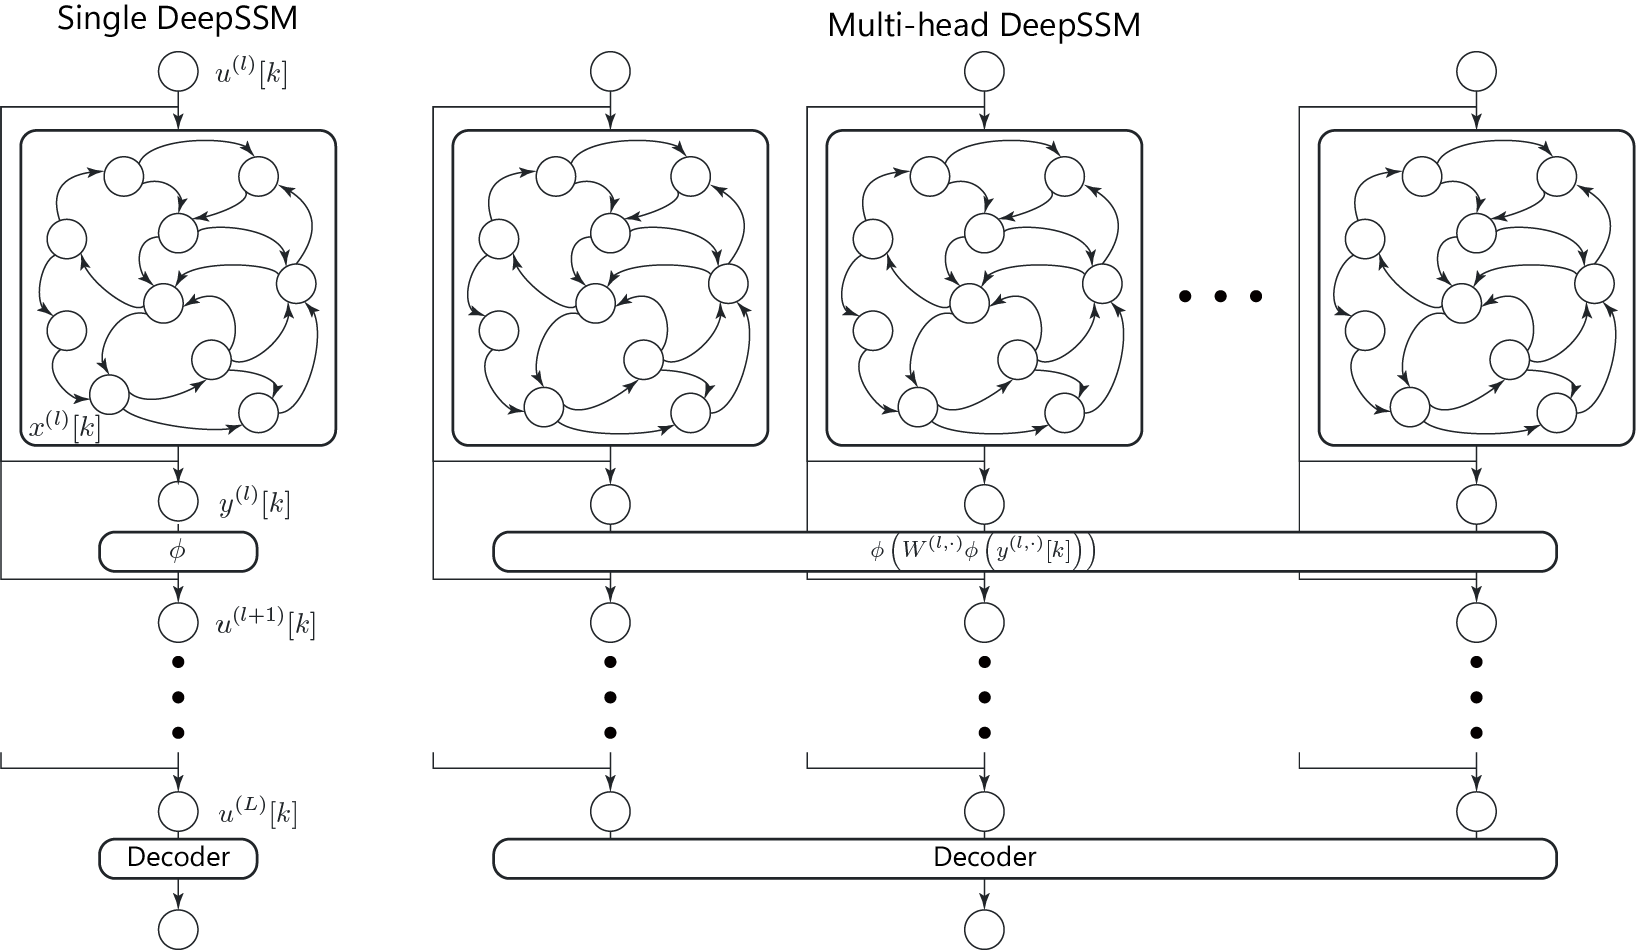
</div>

<figcaption align = "center">

図1 多層SSMの構造。
(左) SSMが直列に接続された多層SSM。 Decoder部分は通常線形層で構成される。
(右) 各層で複数のSSMが並列に接続されたマルチヘッド多層SSM。

</figcaption>

実際には図1(b)に示されるように、各層に $H(>0)$ 個のSSMを並列に配置し、その出力を足し合わせる形で次の層への入力 $u^{(l+1,h)}[k]$ を計算します。
これ自体はTransformerにおけるマルチヘッドアテンションに似た構成で、時定数のパラメータを変化させると多様な時系列を効率よく表現できます。
各層に $H$ 個のSSMがある状況を改めて式で表すと以下のようになります。

$$
\begin{align*}
x^{(l,h)}[k+1] &= \bar{A}^{(l,h)} x^{(l,h)}[k] + \bar{B}^{(l,h)} u^{(l,h)}[k] \\
y^{(l,h)}[k] &= C^{(l,h)} x^{(l,h)}[k] + D^{(l,h)} u^{(l,h)}[k] \\
u^{(l + 1,h)}[k] &= \phi\left(\sum_{o=0}^{H-1} W^{(l,h)}_{o} \phi\left(y^{(l,o)}[k]\right)\right) + u^{(l,h)}[k]
,\end{align*}
$$

添字 $\cdot^{(l,h)}$ は $l$ 層目の $h$ 番目のSSMに対応し、また $u^{(0,h)}[k]:=u[k]$ とします。
$W^{(l,h)} \in \mathbb{R}^{H}$ によって各SSMの出力が足し合わされ、次の層への入力が計算されます。
時系列 $u[k]$ 全体に対して分類や回帰タスクを行う場合は、全 $H$ 個の SSM $\{u^{(L,h)}[T-1]\}_{h=0}^{H-1}$ 、あるいは全時間の平均値である $\{\frac{1}{T}\sum_{k=0}^{T-1} u^{(L,h)}[k]\}_{h=0}^{H-1}$ に対して、典型的には線形層を通して最終的な出力を計算します。
生成や予測タスクに対しては各時刻 $k$ を用いて、同様に何かしらのモデル(こちらも典型的には線形層)を通して出力を計算します。

上記ネットワークは多層SSMで、途中に非線形な活性化関数を挟んでいるので誤差逆伝搬法を用いて学習を行います。
この際、SSMの各パラメータ $\bar{A}^{(l,h)}, \bar{B}^{(l,h)}, C^{(l,h)}, D^{(l,h)}, W^{(l,h)}$ はすべて学習可能なパラメータとして扱います (リザバーとして扱う場合は $\bar{A}$ を固定する状況に相当します)。
どのSSMでも同じ構造を共有するので以下添字を再び省略して表記します。

##### パラメータの設定と初期化

これまで説明されたとおり、SSM $(A, B)$ の計算は (i) 離散化、 (ii) カーネルの計算、 (iii) 畳み込みの3段階で行われます。
特にS4Dの節で説明されたように今、NPLR表現 $A=V(\Lambda - P_V Q_V^{*})V^{*}$ のうち $P=Q=0$ として無視し $V=I$ とした上でZOHで離散化すると (i) と (ii) の計算は大幅に簡略化されます。
このとき長さ $T$ のカーネル $K^{(T)}$ は、Vandermonde行列 $\mathcal{V}^{(T)}(\cdot) \in \mathbb{R}^{N \times T}$ を用いて以下の式で計算されます。

$$
\begin{align*}
\bar{K}^{(T)} &= \left[C\bar{B}, C\bar{A}\bar{B}, C\bar{A}^2\bar{B},~\ldots,~C\bar{A}^{T-1}\bar{B}\right]_{n} \\
&= \left(C \odot \bar{B}^\top \right) \mathcal{V}^{(T)}(\mathrm{diag}(\bar{\Lambda})) \\
&= \left(C \odot \left(\Lambda^{-1}\left(I - \exp(\Delta t \Lambda)\right) B\right)^\top\right)
\mathcal{V}^{(T)}(\mathrm{diag}(\exp(\Delta t\Lambda)))
.\end{align*}
$$

$B, C$はいずれも線形変換であり、したがって $B=1$ として上式の値を変化させないある $C^{'} \in \mathbb{C}^{1 \times N}$ が存在します。
したがって新たにそれを $C$ として定義し直すと、上式は以下の形でさらに簡略化されます。

$$
\begin{align*}
\bar{K}^{(T)} &=
\left(C_n \frac{1-\exp(\Delta t\lambda_n)}{\lambda_n}\right)_{n}^\top
\left(\exp(\Delta t \lambda_n)^k\right)_{k,n}
.\end{align*}
$$

言い換えれば 出力行列 $C$ に全ての変換が集約された形になります。
こうした変形が可能なのがSSM、あるいはLESNの強みと言えるでしょう。
またこれまで $\theta, \tau$ などの時定数を調整するパラメータが用意されましたが、いずれも固有値 $\Lambda$ を定数倍するパラメータなので、$\Delta t$ を調整して $\theta, \tau$ の効果を表現できます。
まとめると学習パラメータは $\Delta t, \Lambda, C, D, W$ で、とくにSSM部分を固定化する場合は $\Delta t, \Lambda$ を固定し、 $C, D, W$ のみを学習可能なパラメータとします。

まず(i)と(ii)をまとめて計算してカーネルを構築する `S4DKernel` を実装しましょう。

In [ ]:
import torch
import torch.nn as nn

default_type = "float32"


class S4DKernel(nn.Module):
    def __init__(
        self,
        num_ssm,
        num_basis,
        rnd=None,
        dtype=default_type,
        dt_min=0.001,
        dt_max=0.1,
        basis_type="s4d_inv",
        tunable_dt=False,
        tunable_basis=False,
    ):
        super(S4DKernel, self).__init__()
        assert num_basis % 2 == 0, "N must be even"
        assert basis_type in ["s4d_inv", "s4d_lin"], 'basis_type must be "s4d_inv" or "s4d_lin"'
        rnd = np.random.default_rng() if rnd is None else rnd

        # Complex output matrix
        C = rnd.normal(0, 1, size=(num_ssm, num_basis // 2, 2)).astype(dtype)  # (H, N/2, 2)
        self.register_parameter("C", nn.Parameter(torch.view_as_complex(torch.from_numpy(C))))

        # Logarithmically spaced time scales
        log_dt = rnd.uniform(np.log10(dt_min), np.log10(dt_max), size=(num_ssm,)).astype(dtype)
        log_dt = torch.from_numpy(log_dt)
        if tunable_dt:
            self.register_parameter("log_dt", nn.Parameter(log_dt))
        else:
            self.register_buffer("dt", nn.Parameter(10**log_dt))

        # Eigenvalues
        A_real = np.full(num_basis // 2, 0.5, dtype=dtype)
        if basis_type == "s4d_inv":
            A_imag = num_basis / np.pi * (num_basis / (2 * np.arange(num_basis // 2, dtype=dtype) + 1) - 1)
        elif basis_type == "s4d_lin":
            A_imag = np.pi * np.arange(num_basis // 2, dtype=dtype)
        if tunable_basis:
            self.register_parameter("log_A_real", nn.Parameter(torch.from_numpy(np.log(A_real))))
            # self.register_buffer("log_A_real", torch.from_numpy(np.log(A_real)))  # for fixed real part
            self.register_parameter("A_imag", nn.Parameter(torch.from_numpy(A_imag)))
        else:
            self.register_buffer("A", torch.from_numpy(A_real + 1j * A_imag))

    @property
    def dt(self):
        return 10**self.log_dt

    @property
    def A(self):
        return -torch.exp(self.log_A_real) + 1j * self.A_imag

    @property
    def eigs(self):
        return torch.exp(self.A * self.dt[:, None])

    def forward(self, time_steps):
        dt = self.dt  # (H,)
        A = self.A  # (N/2,)
        C = self.C  # (H, N/2)

        # Vandermonde multiplication
        dtA = A * dt[:, None]  # (H, N/2)
        C = (2 * C) * (torch.exp(dtA) - 1.0) / A  # (H, N/2)
        K = dtA[..., None] * torch.arange(time_steps, device=A.device)  # (H, N/2, T)
        K = torch.einsum("hn, hnt -> ht", C, torch.exp(K)).real
        return K

この `S4DKernel` は $\Delta t, \Lambda, C$ を学習可能なパラメータとして持ち、 `forward` メソッド (pytorchの `nn.Module` では `__call__`の呼び出しを通して `forward` が呼ばれます) でカーネルを計算します。
デフォルトでは $\Delta t$ ならびに $\Lambda$ は固定化され、$C$ のみが学習可能なパラメータとして扱われます。

まず時間幅 $\Delta t$ は `dt` として保持されています。
`num_ssm`個のSSMが用意されるわけですが、そのダイナミクスの多様性はランダムにサンプルされた $\Delta t$ によって担保しています。
具体的には `dt_min, dt_max` の範囲で対数スケールで一様にサンプリングされています。
一方で学習パラメータとする場合 (`tunable_dt=True`を指定) は `log_dt` として保持し、`exp`を作用させる方法で正の値に制限しています。
これは先程説明したとおり、LESNのスペクトル半径が $\exp(\mathrm{max}(\mathrm{Re}(\lambda_m)) \Delta t)$ となるため、スペクトル半径を1以下に保ち発散を防ぐための工夫です。

固有値 $\Lambda$ は、`A`または`log_A_real, A_imag` の両方で実現されています。
今回実軸対称な固有値のみを考えるので、虚部が正のもののみを計算し、2倍して実部を取れば `num_basis` 次元のSSMの計算と等価な計算ができます。
これが固有値の生成時の引数において `num_basis // 2` が用いられ、かつ `C = (2 * C) * ...` の箇所で2倍されている理由です。
また学習パラメータとする場合 (`tunable_A=True` を指定)では、固有値が実部と虚部に分けられています。
特に`-torch.exp(self.log_A_real)` で実部を負の値に制限していますが、これも同様にスペクトル半径を1以下に保ち、SSMのダイナミクスを安定化させる効果があります。

続けて(iii) の畳み込みを計算する `S4DLayer` を実装しましょう。

In [ ]:
class S4DLayer(nn.Module):
    def __init__(
        self,
        num_ssm,
        num_basis,
        rnd=None,
        dtype=default_type,
        dropout=0.0,
        activation_cls=nn.GELU,
        kernel_cls=S4DKernel,
        **kernel_args,
    ):
        super(S4DLayer, self).__init__()
        rnd = np.random.default_rng() if rnd is None else rnd
        self.D = nn.Parameter(torch.from_numpy(rnd.normal(0.0, 1.0, size=(num_ssm,)).astype(dtype)))  # (H,)

        # SSM Kernel
        self.kernel = kernel_cls(num_ssm, num_basis, rnd=rnd, dtype=dtype, **kernel_args)

        # Position-wise output transform to mix features
        self.output_linear = nn.Sequential(
            activation_cls(),
            nn.Dropout(dropout) if dropout > 0.0 else nn.Identity(),
            nn.Conv1d(num_ssm, num_ssm, kernel_size=1),
            activation_cls(),
        )

    def forward(self, u):
        # Compute SSM Kernel
        time_steps = u.size(-1)
        k = self.kernel(time_steps)  # (H, T)

        # Convolution
        k_f = torch.fft.rfft(k, n=2 * time_steps)  # (H, T)
        u_f = torch.fft.rfft(u, n=2 * time_steps)  # (B, H, T)
        y = torch.fft.irfft(u_f * k_f, n=2 * time_steps)[..., :time_steps]  # (B, H, T)

        # Compute D term in state space equation - essentially a skip connection.
        y = y + u * self.D[..., None]  # (B, H, T)
        y = self.output_linear(y)
        return y

`S4DLayer` では $D$ と $W$ が学習可能なパラメータとして保持されます。
$W$ の実装のため `nn.Conv1D` を用いていますがこれは実質的に線形変換と等価です。
すなわち $H$ 個のSSMの出力を混ぜ合わせ、新たに $H$ 個の出力を生成する線形変換を効率的に計算します。
そして、そのパラメータは $H \times H$ の行列として表現されます。

この `S4DLayer` を並べて多層SSMを実現する `DeepSSM` を実装しましょう。

In [ ]:
class DeepSSM(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        num_layer=1,
        num_ssm=1,
        num_basis=64,
        dropout=0.0,
        prenorm=False,
        average_pool=True,
        **s4d_layer_kwargs,
    ):
        super(DeepSSM, self).__init__()
        self.prenorm = prenorm
        self.average_pool = average_pool

        # Linear encoder (input_dim = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(input_dim, num_ssm)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(num_layer):
            self.norms.append(nn.LayerNorm(num_ssm))
            self.s4_layers.append(S4DLayer(num_ssm, num_basis, dropout=dropout, **s4d_layer_kwargs))
            self.dropouts.append(nn.Dropout(dropout) if dropout > 0.0 else nn.Identity())

        # Linear decoder
        self.decoder = nn.Linear(num_ssm, output_dim)

    def forward(self, x):
        x = self.encoder(x)  # (B, T, input_dim) -> (B, T, H)
        x = x.transpose(-1, -2)  # (B, T, H) -> (B, H, T)
        for norm, layer, dropout in zip(self.norms, self.s4_layers, self.dropouts, strict=True):
            # Each iteration will map (B, H, T) -> (B, H, T)
            z = x
            if self.prenorm:
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)
            z = layer(z)  # Apply S4 block
            z = dropout(z)  # Dropout on the output of the S4 block
            x = z + x  # Residual connection
            if not self.prenorm:
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)
        x = x.transpose(-1, -2)  # (B, H, T) -> (B, T, H)

        if self.average_pool:
            # Average pooling over the sequence length
            out = x.mean(dim=1)  # (B, T, H) -> (B, H)
        else:
            # Taking the last output
            out = x[:, -1, :]  # (B, T, H) -> (B, H)

        # Decode the outputs
        out = self.decoder(out)  # (B, H) -> (B, output_dim)

        # Return the output (B, output_dim)
        return out

非常にシンプルで`input_dim` 次元の入力を `num_layers` 層のSSMに通し、最終的に `output_dim` 次元の出力を生成します。
`self.decoder` は `nn.Linear` で実装される線形変換で、最終層の全 $H$ 個のSSMの出力から`output_dim` 次元の値を生成します。
`average_pool=True` のときは全時間の平均値 $\frac{1}{T} \sum_{k=0}^{T-1} u^{(L, m)}[k]$ を、そうでないときは各時刻 $T-1$ の最終層の状態 $u^{(L, m)}[T-1]$ に対して線形変換を通して出力を計算します。
デフォルトでは `average_pool=False`、すなわち後者が指定されています。

#### Permuted MNIST の学習

##### データセットと学習のコードの準備

ここまででニューラルネットワークのクラスを構築できたので、まずは $28 \times 28$ サイズの手書き画像を入力に10個の数字を分類するタスクであるMNIST<sup>[14]</sup>を学習してみましょう。
MNISTの学習は簡単で単純な全結合型のニューラルネットワークでも98~99%の精度が得られるので、ここではMNISTを難しくした Permuted MNISTを用います。
Permuted MNISTでは各画像のピクセルが784次元の時系列として扱われ、さらにその784次元の時系列は時間方向にランダムにシャッフルされてから入力として与えられます。
この処理によりPermuted MNISTは、長期記憶が必要なより難しいタスクに変化します (ちなみに単に784次元の時系列に置き換えたものはSequence MNISTと呼ばれます。難易度はPermuted MNISTより少し低いですが依然として長期記憶が必要なタスクです)。

まずはデータセットを準備・管理する関数 `load_dataset` と、学習・評価を行う関数 `run_train_and_test`、ならびに描画を管理するクラス`ProgressCallback`を準備しましょう。
コード自体は[標準的なPyTorchによる実装](https://docs.pytorch.org/tutorials/beginner/basics/intro.html)とほぼ同じです。

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from IPython.display import clear_output, display
from ipywidgets import Output
from torch.utils.data import DataLoader


def load_dataset(dataset_type: str) -> datasets.VisionDataset:
    def dataset__init__(self, *args, preprocess=True, **kwargs):
        super(type(self), self).__init__(*args, **kwargs)
        self.preprocess = preprocess
        if self.preprocess:
            if self.transform is not None:
                self.data = self.transform(self.data)
            if self.target_transform is not None:
                self.targets = self.target_transform(self.targets)

    def dataset__getitem__(self, index: int | slice) -> tuple:
        """
        Args:
            index (int | slice): Index or slice object.

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
        if not self.preprocess:
            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                target = self.target_transform(target)
        return img, target

    dataset_cls = getattr(datasets, dataset_type)
    assert issubclass(dataset_cls, datasets.VisionDataset)
    dataset_cls = type(
        dataset_cls.__name__,
        (dataset_cls,),
        {"__init__": dataset__init__, "__getitem__": dataset__getitem__},
    )
    return dataset_cls


def train(model, loader, optimizer, criterion):
    model.train()
    loss_all = []
    pbar = tqdm(loader, leave=False)
    for image, target in pbar:
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        loss_all.append(loss.item())
        optimizer.step()
        pbar.set_postfix(loss=loss_all[-1])
    return loss_all


def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        pbar = tqdm(loader, leave=False)
        for image, target in pbar:
            output = model(image)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return correct / len(loader.dataset)


def run_train_and_test(model, train_loader, test_loader, optimizer, criterion, num_epochs=20, callback=None):
    best_acc = 0.0
    results = dict()
    pbar = trange(1, num_epochs + 1)
    for epoch in pbar:
        loss_all = train(model, train_loader, optimizer, criterion)
        acc = test(model, test_loader)
        if acc > best_acc:
            best_acc = acc
        for name, value in dict(loss=loss_all, acc=acc).items():
            value = np.asarray(value)
            if name not in results:
                results[name] = np.zeros((num_epochs, *value.shape), dtype=value.dtype)
                results[name][:] = np.nan
            results[name][epoch - 1] = value
        pbar.set_postfix(acc=acc, best_acc=best_acc)
        if callback is not None:
            callback(epoch, results)
    return results


class ProgressCallback:
    def __init__(self):
        self.out = Output()
        with self.out:
            fig, ax = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={"wspace": 0.2})
            ax0, ax1 = ax
            ax0.set_title("Training loss", fontsize=14)
            ax1.set_title("Test error", fontsize=14)
            self.fig, self.ax0, self.ax1 = fig, ax0, ax1
        for ax in (self.ax0, self.ax1):
            ax.tick_params(axis="both", which="both", labelsize=12)
            ax.grid(which="both", ls=":")
            ax.set_yscale("log")

    def __call__(self, epoch, results):
        if epoch == 1:
            display(self.out)
        loss_all = results["loss"][epoch - 1]
        best_acc_pos = np.nanargmax(results["acc"][:epoch])
        best_acc = results["acc"][best_acc_pos]
        self.ax0.plot(np.linspace(epoch - 1, epoch, len(loss_all) + 1)[:-1], loss_all, lw=0.5)
        self.ax0.set_xticks(np.arange(0, epoch + 1, max(epoch // 5, 1)))

        self.ax1.cla()
        self.ax1.plot(np.arange(1, len(results["acc"]) + 1), 1 - results["acc"], lw=1)
        self.ax1.scatter(best_acc_pos + 1, 1 - best_acc, color="red", s=40, marker="*")
        self.ax1.set_xticks(np.arange(1, epoch + 1, max(epoch // 5, 1)))
        self.ax1.set_title(f"Test error (best: {1 - best_acc:.4f})", fontsize=14)
        self.ax1.grid(which="both", ls=":")
        self.ax1.set_yscale("log")
        with self.out:
            clear_output(wait=True)
            display(self.fig)

    def close(self):
        plt.close(self.fig)

試しにPermuted MNISTのデータセットを描画して、タスクの内容を確認してみましょう。

In [ ]:
shuffle_id = np.random.default_rng(1234).permutation(784)  # Shuffle pixels.
dataset_cls = load_dataset("MNIST")
transform_kwargs = dict(
    preprocess=True,  # Preprocess the data when loading the dataset.
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).to("cpu")),
            transforms.Lambda(
                lambda x: x.view(-1, 784, 1)[:, shuffle_id, :] / 255.0
            ),  # Shuffle and normalize to [0, 1].
        ]
    ),
    target_transform=transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x, dtype=np.uint8)).to("cpu")),
)
dataset = dataset_cls(root="./.cache", train=False, download=True, **transform_kwargs)

plot_num = 4
plot_label = [2, 3, 5, 7]
width_ratio, cell_size = 4.0, 1.5
grid_size = (len(plot_label), plot_num * 2 + 1)
fig, ax = plt.subplots(
    *grid_size,
    figsize=((plot_num * 2 + width_ratio) * cell_size, grid_size[0] * cell_size),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05, "width_ratios": [1] * plot_num * 2 + [width_ratio]},
)

recover_id = np.argsort(shuffle_id)  # Recover the original pixel order.
for idx, label in enumerate(plot_label):
    indices = np.where(dataset.targets.numpy() == label)[0][:plot_num]
    ax[idx, 0].set_ylabel(f"Label: {label}", fontsize=12)
    for idy, index in enumerate(indices):
        image, target = dataset[index]
        ax[idx, idy].imshow(image[recover_id].view(28, 28).numpy(), cmap="gray", vmin=0.0, vmax=1.0)
        ax[idx, idy].axis("off")
        ax[idx, idy + plot_num].imshow(image.view(28, 28).numpy(), cmap="gray", vmin=0.0, vmax=1.0)
        ax[idx, idy + plot_num].axis("off")
        ax[idx, -1].plot(image.view(784).numpy(), lw=0.5)
    ax[idx, -1].set_yticklabels([])
    if idx < len(plot_label) - 1:
        ax[idx, -1].set_xticklabels([])

左側には元の画像、中央にはシャッフルされた画像、そして右側には784次元の時系列として描画された入力データが示されています。
左側の画像からは数字を認識できますが、中央のシャッフルされた画像からはもはや何の数字か読み取れません。
ただ全結合型のニューラルネットワークでは、一度に784次元の入力を受け取れるので、シャッフルの仕方が固定ならば問題なく学習が可能です。
そこでPermuted MNISTでは784ステップの時系列として順次が入力として与えてタスクの難しさを担保しています。
タスクの難しさを直感的に理解できましたでしょうか？

##### 学習の実行

さて準備が整ったので学習に移ります。
以下のコードはデフォルトでは　$(L, H, N) = (4, 64, 64)$ の条件でDeepSSMを構築し、最終ステップの最終層のSSMの出力のみを参照(`average_pool=False`)して、Permuted MNISTの学習を行います。
果たしてどの程度の精度が得られるでしょうか？(実行環境にもよりますがGPUを用いて数分程度で学習が完了すると思います)

In [ ]:
permute_seed, model_seed, training_seed = 123, 456, 789  # Random seeds (permute pixels, model init, training)
input_dim, output_dim = 1, 10
num_layer, num_ssm, num_basis = 4, 64, 64
dt_min, dt_max = 1e-4, 1e-2  # Range of time scales for S4D layers
dropout, prenorm, average_pool = 0.0, False, False
tunable_dt, tunable_basis = False, False  # Whether to make dt and basis parameters trainable (default: False)
basis_type = "s4d_inv"  # "s4d_inv" or "s4d_lin"
epoch_num, batch_size = 20, 128
learning_rate = 1e-3

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load dataset
shuffle_id = np.random.default_rng(permute_seed).permutation(784)  # Shuffle pixels
# shuffle_id = np.arange(784)  # No shuffle (a.k.a. Sequential MNIST), uncomment it to see the effect of pixel permutation.
dataset_cls = load_dataset("MNIST")  # You can change it to "FashionMNIST" or "KMNIST".
transform_kwargs = dict(
    preprocess=True,  # Preprocess the data when loading the dataset.
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).to(device)),
            transforms.Lambda(
                lambda x: x.view(-1, 784, 1)[:, shuffle_id, :] / 255.0
            ),  # Shuffle and normalize to [0, 1].
        ]
    ),
    target_transform=transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x, dtype=np.uint8)).to(device)),
)
train_dataset = dataset_cls(root="./.cache", train=True, download=True, **transform_kwargs)
test_dataset = dataset_cls(root="./.cache", train=False, download=True, **transform_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Build model
model = DeepSSM(
    input_dim=input_dim,
    output_dim=output_dim,
    num_layer=num_layer,
    num_ssm=num_ssm,
    num_basis=num_basis,
    dropout=dropout,
    prenorm=prenorm,
    average_pool=average_pool,
    rnd=np.random.default_rng(model_seed),
    dt_min=dt_min,
    dt_max=dt_max,
    basis_type=basis_type,
    tunable_dt=tunable_dt,
    tunable_basis=tunable_basis,
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# run training
torch.manual_seed(training_seed)
callback = ProgressCallback()
results = run_train_and_test(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    num_epochs=epoch_num,
    callback=callback,
)
callback.close()

デフォルトではおそらく `s4d-inv`と`s4d-lin` のいずれも94〜96%程度の精度 (4〜6%程度の誤差率) に到達すると思います。
時間がかかってしまいますが、SSMのパラメータ数を調整する $L, H, N$ やエポック数を増やしたり、学習率やドロップアウト率を調整するとさらに精度が向上し、97〜98%程度の精度が得られると思います。
このあたり実際に試行錯誤してみてハイパーパラメータと精度の関係を確認してください。

また $\Delta t$ のレンジを調整する `dt_min, dt_max` の値が特に学習に影響を与えます。
というのも今回長さ784ステップの時系列データを扱っているため、これより早いスケール (1/784程度 以上の値) で $\Delta t$ を設定してしまうと、SSMのダイナミクスの減衰が早すぎて十分に情報を保持できないからです。
試しに `dt_min=1e-3, dt_max=1e-1` と設定して学習が破綻する様子も確認してください。

以下のセルは各SSM $(A, B)$ (すなわちLESN $(\bar{A}, \bar{B})$ ) の固有値を描画します。
うまく行く場合と行かない場合で固有値がどう変化するか確認してみてください。

In [ ]:
def plot_diag_eigen(ax, values):
    ts = np.linspace(0, 2 * np.pi, 1001)
    cs = np.linspace(0, 1.0, len(values))
    color = plt.get_cmap("hsv")(cs)

    ax.tick_params(axis="both", labelsize=12)
    ax.scatter(values.real, values.imag, s=3.0, c=color)
    ax.scatter(values.real, -values.imag, s=3.0, c=color)
    ax.plot(np.cos(ts), np.sin(ts), lw=0.5, ls="--", color="k")
    ax.set_aspect("equal", adjustable="datalim")
    ax.grid(which="both", ls=":")
    return ax


def plot_diag_eigen_all(model, plot_num=4):
    plot_num = min(plot_num, model.s4_layers[0].kernel.eigs.size(0))
    grid_size = (len(model.s4_layers), plot_num)
    fig, ax = plt.subplots(
        *grid_size, figsize=(2 * grid_size[1], 2 * grid_size[0]), gridspec_kw={"hspace": 0.25, "wspace": 0.25}
    )

    for idx, layer in enumerate(model.s4_layers):
        eigs = layer.kernel.eigs.detach().cpu().numpy()
        for pos in range(plot_num):
            plot_diag_eigen(ax[idx, pos % plot_num], eigs[pos])
            if idx == 0:
                ax[idx, pos % plot_num].set_title(f"$\\Delta t_{{{pos}}}$", fontsize=14)
        ax[idx, 0].set_ylabel(f"Layer {idx + 1}", fontsize=12)
    return fig, ax


fig, ax = plot_diag_eigen_all(model, plot_num=4)

##### 標準的なLESNとの比較

ここまで扱った固有値の初期化の工夫の効果を確認するため、標準的なLESNを用いたDeepSSMと比較してみましょう。
これまでの章で扱いましたが、ESNは通常正規分布 $\mathcal{N}(0, 1/N)$ からサンプリングされたランダム行列を内部結合行列として使用します。
これは、このようにしてサンプルされた行列は、サイズが十分に大きい場合、複素平面上の単位円板上で一様に分布する固有値を持つので (Cf. [円則](https://en.wikipedia.org/wiki/Circular_law))、概ね内部行列のスペクトル半径を1に設定できるからです。
逆に言えば、複素平面上での単位円板上で一様に分布するように複素数を $N$ 個サンプリングし構築されたカーネルは、標準的なLESNによるそれと実質的に同等であると考えられます。
ただ通常LESNでは時間幅 $\Delta t$ を持たず、内部結合の違いで時定数が表現されるので、その固有値を改めて $\{\bar{\lambda}_n\}_n$ として以下の形でカーネルを計算します。

$$
\begin{align*}
\bar{K}^{(T)} &=
\left(C_n \bar{\lambda}_n^k\right)_{k,n}
.\end{align*}
$$

これまでは $\exp\left(\lambda_n \Delta t\right)$ が $\bar{A}$ の固有値でしたが、ここでは $\bar{\lambda}_n$ のみで全体を表現している点に注意してください。
以下のセルでそのようなカーネルの計算を行う `LESNKernel` を実装してみましょう。

In [ ]:
import torch
import torch.nn as nn

default_type = "float32"


def sample_random_eigs(num_ssm, num_basis, rnd=None, dtype=default_type, radius_min=0.0, radius_max=0.95, **_kwargs):
    rnd = np.random.default_rng() if rnd is None else rnd
    radius = rnd.uniform(radius_min**2, radius_max**2, size=(num_ssm, num_basis // 2)).astype(dtype) ** 0.5
    angle = rnd.uniform(0.0, np.pi, size=(num_ssm, num_basis // 2)).astype(dtype)
    eigs = radius * np.exp(1j * angle)
    return eigs


class LESNKernel(nn.Module):
    def __init__(
        self,
        num_ssm,
        num_basis,
        rnd=None,
        eigen_func=sample_random_eigs,
        dtype=default_type,
        tunable_eigen=False,
        **eigen_func_kwargs,
    ):
        super(LESNKernel, self).__init__()
        assert num_basis % 2 == 0, "N must be even"
        rnd = np.random.default_rng() if rnd is None else rnd

        # Complex output matrix
        C = rnd.normal(0, 1, size=(num_ssm, num_basis // 2, 2)).astype(dtype)  # (H, N/2, 2)
        self.register_parameter("C", nn.Parameter(torch.view_as_complex(torch.from_numpy(C))))

        # Eigenvalues
        eigs = eigen_func(num_ssm, num_basis, rnd=rnd, dtype=dtype, **eigen_func_kwargs)  # (H, N/2)
        if tunable_eigen:
            A_abs, A_angle = np.abs(eigs), np.angle(eigs)
            self.register_parameter("log_log_A_abs", nn.Parameter(torch.from_numpy(np.log(-np.log(A_abs)))))
            self.register_parameter("A_angle", nn.Parameter(torch.from_numpy(A_angle)))
        else:
            self.register_buffer("A", torch.from_numpy(eigs))

    @property
    def A(self):
        return torch.exp(-torch.exp(self.log_log_A_abs) + 1j * self.A_angle)

    @property
    def eigs(self):
        return self.A

    def forward(self, time_steps):
        A = self.A  # (H, N/2)
        C = self.C  # (H, N/2)
        # Vandermonde multiplication
        K = A[..., None] ** torch.arange(time_steps, device=A.device)  # (H, N/2, T)
        K = torch.einsum("hn, hnt -> ht", 2 * C, K).real
        return K

`sample_random_eigs` はノルムが $(r_\mathrm{min}, r_\mathrm{max})$ の範囲、偏角が $[0, \pi)$ の範囲で一様に分布するように複素数をサンプリングします。
したがって例えば `r_min=0.0, r_max=0.9` とすると、スペクトル半径が0.9未満程度のLESNを模倣したLESNによるカーネルが得られます。
この条件でPermuted MNISTを学習してみましょう。
以下のコードは、カーネルの設定以外は先ほどのセルと同じ条件で学習を行います。

In [ ]:
permute_seed, model_seed, training_seed = 123, 456, 789  # Random seeds (permute pixels, model init, training)
input_dim, output_dim = 1, 10
num_layer, num_ssm, num_basis = 4, 64, 64
dropout, prenorm, average_pool = 0.0, False, False
tunable_eigen = False  # Whether to make basis parameters trainable (default: False)
epoch_num, batch_size = 20, 128
learning_rate = 1e-3
radius_min, radius_max = 0.0, 0.9  # Range of radius of eigenvalues for LESNKernel

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load dataset
shuffle_id = np.random.default_rng(permute_seed).permutation(784)  # Shuffle pixels
# shuffle_id = np.arange(784)  # No shuffle (a.k.a. Sequential MNIST), uncomment it to see the effect of pixel permutation
dataset_cls = load_dataset("MNIST")  # You can change it to "FashionMNIST" or "KMNIST"
transform_kwargs = dict(
    preprocess=True,  # Preprocess the data when loading the dataset
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).to(device)),
            transforms.Lambda(
                lambda x: x.view(-1, 784, 1)[:, shuffle_id, :] / 255.0
            ),  # Shuffle and normalize to [0, 1]
        ]
    ),
    target_transform=transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x, dtype=np.uint8)).to(device)),
)
train_dataset = dataset_cls(root="./.cache", train=True, download=True, **transform_kwargs)
test_dataset = dataset_cls(root="./.cache", train=False, download=True, **transform_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Build model
model = DeepSSM(
    input_dim=input_dim,
    output_dim=output_dim,
    num_layer=num_layer,
    num_ssm=num_ssm,
    num_basis=num_basis,
    dropout=dropout,
    prenorm=prenorm,
    average_pool=average_pool,
    kernel_cls=LESNKernel,  # NOTE: Use LESNKernel instead of S4DKernel.
    rnd=np.random.default_rng(model_seed),
    tunable_eigen=tunable_eigen,
    eigen_func=sample_random_eigs,  # Argument for LESNKernel
    radius_min=radius_min,
    radius_max=radius_max,
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training phase
torch.manual_seed(training_seed)
callback = ProgressCallback()
results = run_train_and_test(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    num_epochs=epoch_num,
    callback=callback,
)
callback.close()

精度が90%程度で頭打ちとなる様子が確認できると思います。
通常のMNISTが線形モデルでも92%程度の精度が得られるので、これはあまり良い結果とは言えません。
この原因ですが固有値の分布が複素平面上の円板上に一様に分布しており、Permuted MNISTに必要な時定数の長い成分が不足しているためです。
実際にS4Dでの固有値がほぼ単位円周上に分布していた点を思い出してください (`plot_diag_eigen_all(model)`を実行するとここでも固有値の分布を確認できます)。

したがってこの設定でも $r_\mathrm{min}, r_\mathrm{max}$ を1に近づけると精度が向上すると期待されます。
試しに、このS4Dの設定に倣って `radius_min=0.99, radius_max=1.0` として再実行してみてください。
先程のS4Dと同等、あるいはそれ以上の精度が得られると思います。

このようにSSMの固有値の初期化次第で、SSMの長期記憶特性と学習の成否が大きく変わります。
そしてSSMの長期記憶特性は、緩やかに減衰する様々な周波数特性をもつ固有値 (絶対値が1に近く偏角が多様) によって実現されていると考えられます。

#### その他のタスク (Advanced)

ここまでPermuted MNISTを例に学習の様子を確認しましたが、冒頭に述べられたように、SSMは長期記憶特性がより必要な様々なタスクに応用できます。
またPermuted MNISTのような識別タスクのみならず、音声合成や画像生成などの生成タスクにも応用できます。
ただしPermuted MNISTに比べて計算リソースが必要になる場合が多いので、ここでは紹介のみに留めます。
以下発展課題として記載しておくので、興味があればぜひ試してみてください。

Q5.1. (Advanced)

- CIFAR10は $32 \times 32$ サイズのRGB画像を10クラスに分類するタスクである。このCIFAR10に関してもMNIST同様にSequential / Permuted CIFAR10を構築し、DeepSSMを用いて学習を行え。
  - メモ1: 入力の次元が3 (RGB) なので、`input_dim=3` とする。
  - メモ2: 画像を $32 \times 32 = 1024$ ステップの時系列として扱う。
  - メモ3: S4論文<sup>[5]</sup>では、$(L, H, N)=(6,1024,64)$ の条件でかつ`dropout=0.25`を指定して学習している。実行環境によっては時間がかかるので、適宜パラメータを調整しながら参考にせよ。
  - メモ4: 読み込みに関しては以下のコードを参考にせよ。

```python
device = "cuda" if torch.cuda.is_available() else "cpu"
shuffle_id = np.arange(1024)  # Sequential CIFAR10
# shuffle_id = np.random.default_rng(1234).permutation(1024)  # Permuted CIFAR10
dataset_cls = load_dataset("CIFAR10")
transform_kwargs = dict(
    preprocess=True,  # Preprocess the data when loading the dataset
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).to(device)),
            transforms.Lambda(
                lambda x: x.view(-1, 1024, 3)[:, shuffle_id, :] / 255.0
            ),  # Shuffle and normalize to [0, 1]
        ]
    ),
    target_transform=transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x, dtype=np.uint8)).to(device)),
)
train_dataset = dataset_cls(root="./.cache", train=True, download=True, **transform_kwargs)
test_dataset = dataset_cls(root="./.cache", train=False, download=True, **transform_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for image, target in train_loader:
    print(image.shape, image.dtype, image.device)
    print(target.shape, target.dtype, target.device)
    break

```

Q5.2. (Advanced)

- [LRA](https://github.com/google-research/long-range-arena)のPathfinderに関してにも同様に`DeepSSM`を用いて学習を行え。
    - メモ1: https://storage.googleapis.com/long-range-arena/lra_release.gz からダウンロードできる。ただしファイルのサイズ(8GB程度)が大きくかつ解凍に時間がかかるので注意。
    - メモ2: 入力の次元が1 (グレースケール) なので、`input_dim=1` とする。
    - メモ3: Pathfinderは画像中の２つのマーカーが線によってつながっているか否かを分類するタスクである。したがって2クラス分類なので`output_dim=2`とする。
    - メモ4: 難易度に応じて画像サイズが $N=32, 64, 128, 256$ となる4種類のタスクが用意されている。いずれもピクセルをランダムにシャッフルしてから $N^2$ ステップの時系列として扱う 。まずは $N=32$ から試し、徐々にサイズを大きくしていくとよい。
    - メモ5: 読み込みのためのデータローダーを実装しなければならない。[Pytorch公式のチュートリアル](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)を参考にせよ。
- LRAの他のタスクに関しても余力があれば実装せよ。

Q5.3. (Advanced)

- S4・S4Dは識別タスクだけでなく、生成タスクにも応用できる。[元論文のS4のデモンストレーション](https://srush.github.io/annotated-s4/)に倣って音声、あるいは画像生成モデルを実装せよ。
    - メモ1: 実はこれまで用意したコードの僅かな改変で実現できる。すなわち識別モデル(`DeepSSM`の`self.decoder`に相当する部分)を、例えば次の時刻のピクセル、あるいは音声波形を予測するようなデコーダモデルに置き換えればよい。
    - メモ2: 学習時は今までのコードとおり、全時系列 $u[k]$ を与えて、得られた $x[k]$ から $u[k+1]$ を予測するようにデコーダモデルを学習すればよい。これはこれまで学習したopen-loopでデータを収集し、closed-loopを構築するRCの学習方法と似ている。
    - メモ3: 生成時はTransformerなどの自己回帰モデルと同様に、時々刻々処理する形式に変更する必要がある。この場合FFTを用いるよりも、直接ダイナミクスを計算して時々刻々出力させるほうが効率的である。

## 参考文献

[1] Jaeger, H. (2001). *Short term memory in echo state networks*. GMD Forschungszentrum Informationstechnik. https://doi.org/10.24406/publica-fhg-291107

[2] Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2019). *Language models are unsupervised multitask learners.* OpenAI blog, 1(8), 9.

[3] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2023). *Attention Is All You Need* (No. arXiv:1706.03762). arXiv. https://doi.org/10.48550/arXiv.1706.03762

[4] Tay, Y., Dehghani, M., Abnar, S., Shen, Y., Bahri, D., Pham, P., Rao, J., Yang, L., Ruder, S., & Metzler, D. (2020). *Long Range Arena: A Benchmark for Efficient Transformers* (No. arXiv:2011.04006). arXiv. https://doi.org/10.48550/arXiv.2011.04006

[5] Gu, A., Dao, T., Ermon, S., Rudra, A., & Re, C. (2020). *HiPPO: Recurrent Memory with Optimal Polynomial Projections* (No. arXiv:2008.07669). arXiv. https://doi.org/10.48550/arXiv.2008.07669

[6] Gu, A., Goel, K., & Ré, C. (2022). *Efficiently Modeling Long Sequences with Structured State Spaces* (No. arXiv:2111.00396). arXiv. https://doi.org/10.48550/arXiv.2111.00396

[7] Gu, A., Gupta, A., Goel, K., & Ré, C. (2022). *On the Parameterization and Initialization of Diagonal State Space Models* (No. arXiv:2206.11893). arXiv. https://doi.org/10.48550/arXiv.2206.11893

[8] Gu, A., Johnson, I., Timalsina, A., Rudra, A., & Ré, C. (2022). *How to Train Your HiPPO: State Space Models with Generalized Orthogonal Basis Projections* (No. arXiv:2206.12037). arXiv. https://doi.org/10.48550/arXiv.2206.12037

[9] Gu, A., & Dao, T. (2024). *Mamba: Linear-Time Sequence Modeling with Selective State Spaces* (No. arXiv:2312.00752). arXiv. https://doi.org/10.48550/arXiv.2312.00752

[10] LeCun, Y., Bengio, Y., & Hinton, G. (2015). *Deep learning. Nature, 521(7553)*, 436–444. https://doi.org/10.1038/nature14539

[11] Ma, Q., Shen, L., & Cottrell, G. W. (2017). *Deep-ESN: A Multiple Projection-encoding Hierarchical Reservoir Computing Framework* (No. arXiv:1711.05255). arXiv. https://doi.org/10.48550/arXiv.1711.05255

[12] Guan, J., Kubota, T., Kuniyoshi, Y., & Nakajima, K. (2025). *Memory Determines Learning Direction: A Theory of Gradient-Based Optimization in State Space Models* (No. arXiv:2510.00563; Version 1). arXiv. https://doi.org/10.48550/arXiv.2510.00563

[13] Gupta, A., Gu, A., & Berant, J. (2022). *Diagonal State Spaces are as Effective as Structured State Spaces* (No. arXiv:2203.14343). arXiv. https://doi.org/10.48550/arXiv.2203.14343

[14] Deng, L. (2012). *The MNIST Database of Handwritten Digit Images for Machine Learning Research [Best of the Web]*. IEEE Signal Processing Magazine, 29(6), 141–142. https://doi.org/10.1109/MSP.2012.2211477